In [2]:
####
# BLOCO DE BIBLIOTECAS AUXILIARES 
####

import pandas as pd
import numpy as np
import requests
import time
import os
import zipfile
import re
import io
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.stats.api as sms
from tqdm import tqdm
from scipy import stats
from scipy.stats import chi2
from linearmodels import PooledOLS, RandomEffects, PanelOLS
from linearmodels.iv import IV2SLS

In [1]:
# ============================================================#
# ===  BLOCO 1:   COLETA DE DADOS DA API DO SICONFI         ==#
# ============================================================#
### /!\ ATENÇÃO: A COLETA PODE DEMORAR EM TORNO DE 15MIN E CONSUMIR RAM

import requests
import pandas as pd
import time, os, zipfile
from tqdm import tqdm

# params

URL = "https://apidatalake.tesouro.gov.br/ords/siconfi/tt/dca"
ESTADOS = {
    "AC": 12, "AL": 27, "AM": 13, "AP": 16, "BA": 29, "CE": 23, "DF": 53, "ES": 32, "GO": 52,
    "MA": 21, "MG": 31, "MS": 50, "MT": 51, "PA": 15, "PB": 25, "PE": 26, "PI": 22, "PR": 41,
    "RJ": 33, "RN": 24, "RO": 11, "RR": 14, "RS": 43, "SC": 42, "SE": 28, "SP": 35, "TO": 17
}
ANOS = range(2015, 2026)

DESTINO = ""
CSV_FILE = os.path.join(DESTINO, "dca_estados_2015_2025.csv")
ZIP_FILE = os.path.join(DESTINO, "dca_estados_2015_2025.zip")

# =====

def fetch_dca(ano: int, cod_ibge: int, uf: str, session: requests.Session, limit=5000, max_retries=3):
    offset = 0
    out = []
    while True:
        params = {"an_exercicio": ano, "id_ente": cod_ibge, "offset": offset}
        tries = 0
        while True:
            try:
                r = session.get(URL, params=params, timeout=30)
                if r.status_code == 200:
                    break
                tries += 1
                if tries >= max_retries:
                    print(f"{uf}-{ano}: HTTP {r.status_code} em offset {offset}")
                    return out
                time.sleep(2 * tries)
            except Exception as e:
                tries += 1
                if tries >= max_retries:
                    print(f"{uf}-{ano}: erro {e} em offset {offset}")
                    return out
                time.sleep(2 * tries)

        data = r.json()
        items = data.get("items", [])
        if not items:
            break
        for i in items:
            i["ano"] = ano
            i["uf"] = uf
        out.extend(items)

        if len(items) < limit:
            break
        offset += limit
        time.sleep(1)
    return out

# ===== Coleta =====
session = requests.Session()
dados = []

for uf, cod_ibge in tqdm(ESTADOS.items(), desc="UFs"):
    for ano in ANOS:
        chunk = fetch_dca(ano, cod_ibge, uf, session)
        dados.extend(chunk)
        time.sleep(1)

# ===== DF =====
df = pd.DataFrame(dados)
cols = [c for c in ["uf", "ano", "anexo", "coluna", "conta", "valor"] if c in df.columns]
df = df[cols].drop_duplicates().sort_values(["uf", "ano"])

# ===== Salvar CSV + ZIP =====
df.to_csv(CSV_FILE, index=False, encoding="utf-8-sig")
with zipfile.ZipFile(ZIP_FILE, "w", zipfile.ZIP_DEFLATED) as z:
    z.write(CSV_FILE)


print(f"CSV: {CSV_FILE}  ({round(os.path.getsize(CSV_FILE)/1024/1024,1)} MB)")
print(f"ZIP: {ZIP_FILE}  ({round(os.path.getsize(ZIP_FILE)/1024/1024,1)} MB)")


UFs: 100%|██████████| 27/27 [14:05<00:00, 31.30s/it]


CSV: dca_estados_2015_2025.csv  (81.8 MB)
ZIP: dca_estados_2015_2025.zip  (9.6 MB)


In [6]:
# ==========================================================================#
# === BLOCO 2: DCA Estados | Despesas Empenhadas e Liquidadas (I-E + I-D) ==#
# ==========================================================================#
#
CSV_DCA = "dca_estados_2015_2025.csv"
UF = "MG"  # -----> ESTADO A SER ANALISADO

FUNCOES = {
    "SAUDE": "10",
    "EDUCACAO": "12",
    "COMUNICACAO": "13",
    "URBANISMO": "15",
    "HABITACAO": "16",
    "SANEAMENTO": "17",
    "TRANSPORTE": "26",
}

#
def norm(s: str) -> str:
    s = (s or "").upper()
    return (s.replace("Á", "A").replace("Â", "A").replace("Ã", "A")
             .replace("É", "E").replace("Ê", "E")
             .replace("Í", "I").replace("Ó", "O").replace("Õ", "O")
             .replace("Ú", "U").replace("Ç", "C"))

def br(x):
    try:
        return f"{x:,.0f}".replace(",", "X").replace(".", ",").replace("X", ".")
    except:
        return x

#
df = pd.read_csv(CSV_DCA)
for c in ["uf","anexo","coluna","conta"]: df[c] = df[c].astype(str)
df["ano"]       = pd.to_numeric(df["ano"], errors="coerce").astype("Int64")
df["valor_num"] = pd.to_numeric(df["valor"], errors="coerce")

#
def processar_despesas(coluna: str):
    """Processa uma coluna (Empenhadas ou Liquidadas) e retorna DataFrame com funções + total geral."""
    base = df[(df["uf"].str.upper() == UF) & (df["coluna"] == coluna)].copy()

    #
    ie = base[base["anexo"].str.contains("I-E", case=False, na=False)].copy()
    ie["conta_n"]   = ie["conta"].map(norm)
    ie["cod_func"]  = ie["conta_n"].str.extract(r"^\s*(\d{2})")[0]
    ie["is_funcao"] = ie["conta_n"].str.match(r"^\s*(10|12|13|15|16|17|26)\s*-\s+[A-Z ]+$")
    ie["is_sub"]    = ie["conta_n"].str.match(r"^\s*(10|12|13|15|16|17|26)\.\d+\s*-\s+")

    anos = sorted(ie["ano"].dropna().unique())
    series = {}

    for nome, cod in FUNCOES.items():
        sub = ie[ie["cod_func"] == cod]
        fun_top = sub[sub["is_funcao"]].groupby("ano")["valor_num"].sum()
        fun_sub = sub[sub["is_sub"]].groupby("ano")["valor_num"].sum()
        series[nome] = pd.Series(
            [fun_top.get(a, fun_sub.get(a, np.nan)) for a in anos], index=anos, name=nome
        )

    matriz = pd.DataFrame(series, index=anos).sort_index()
    matriz["TOTAL_FUNCOES_IE"] = matriz.sum(axis=1, skipna=True)

    #
    id_ = base[base["anexo"].str.contains("I-D", case=False, na=False)].copy()
    id_total = id_[id_["conta"].str.upper().str.contains("TOTAL GERAL")]
    tot_id = id_total.groupby("ano")["valor_num"].sum().rename("TOTAL_GERAL_ID")
    matriz = matriz.join(tot_id, how="left")

    return matriz

#
matriz_empenhadas = processar_despesas("Despesas Empenhadas")
matriz_liquidadas = processar_despesas("Despesas Liquidadas")

#
matriz_fmt_emp = matriz_empenhadas.copy()
matriz_fmt_liq = matriz_liquidadas.copy()
for c in matriz_fmt_emp.columns: matriz_fmt_emp[c] = matriz_fmt_emp[c].map(br)
for c in matriz_fmt_liq.columns: matriz_fmt_liq[c] = matriz_fmt_liq[c].map(br)

print(f"=== {UF} — Despesas Empenhadas | I-E (funções padrão) + I-D (Total Geral) ===")
display(matriz_fmt_emp.reset_index().rename(columns={"index":"ano"}))

print(f"=== {UF} — Despesas Liquidadas | I-E (funções padrão) + I-D (Total Geral) ===")
display(matriz_fmt_liq.reset_index().rename(columns={"index":"ano"}))




=== MG — Despesas Empenhadas | I-E (funções padrão) + I-D (Total Geral) ===


,ano,SAUDE,EDUCACAO,COMUNICACAO,URBANISMO,HABITACAO,SANEAMENTO,TRANSPORTE,TOTAL_FUNCOES_IE,TOTAL_GERAL_ID
0,2015,7.803.272.984,8.527.865.730,154.978.653,190.125.572,77.258.464,228.481.852,958.306.096,17.940.289.351,85.119.036.086
1,2016,7.944.124.557,9.950.115.562,153.578.098,212.376.944,42.768.128,63.073.232,999.674.504,19.365.711.024,88.129.098.218
2,2017,8.528.188.684,10.444.179.678,146.111.604,176.870.472,32.312.319,77.859.073,921.408.677,20.326.930.507,98.391.669.163
3,2018,7.439.918.439,9.849.272.725,145.462.982,147.978.149,51.833.824,43.061.759,803.325.423,18.480.853.301,102.986.641.549
4,2019,10.104.635.968,9.519.639.176,124.573.687,81.962.303,23.301.478,38.042.571,553.873.021,20.446.028.202,108.180.584.581
5,2020,9.731.140.968,8.818.856.449,239.949.914,112.541.293,38.443.136,30.991.774,533.037.118,19.504.960.652,107.107.557.290
6,2021,11.749.023.842,13.549.045.426,120.918.273,185.804.851,27.948.224,2.084.407.865,1.233.353.002,28.950.501.483,128.891.804.747
7,2022,12.179.419.491,16.094.953.943,121.098.609,440.844.209,23.053.543,443.436.479,2.033.014.560,31.335.820.834,116.489.779.177
8,2023,13.530.703.581,16.626.483.088,128.176.015,565.651.912,98.538.583,64.693.969,2.434.582.771,33.448.829.919,110.408.991.646
9,2024,14.220.754.004,18.453.780.878,342.191.988,340.865.459,30.433.915,56.413.763,2.236.653.699,35.681.093.704,118.410.573.407


=== MG — Despesas Liquidadas | I-E (funções padrão) + I-D (Total Geral) ===


,ano,SAUDE,EDUCACAO,COMUNICACAO,URBANISMO,HABITACAO,SANEAMENTO,TRANSPORTE,TOTAL_FUNCOES_IE,TOTAL_GERAL_ID
0,2015,6.275.143.805,7.666.237.373,141.472.210,122.174.184,64.516.799,193.687.739,905.918.305,15.369.150.416,80.794.040.639
1,2016,6.138.940.988,8.696.950.955,127.238.210,166.136.981,38.047.177,55.985.564,773.888.869,15.997.188.745,83.365.212.064
2,2017,5.883.980.086,9.095.941.998,135.903.273,150.275.764,31.032.516,54.165.371,717.308.229,16.068.607.237,92.129.724.412
3,2018,5.944.006.795,9.199.226.767,135.604.159,127.168.619,49.103.202,24.983.961,724.465.254,16.204.558.757,98.381.285.416
4,2019,7.725.198.838,9.305.700.224,118.647.359,58.171.262,22.057.648,14.893.019,483.941.833,17.728.610.183,103.025.640.362
5,2020,8.456.617.593,8.624.846.434,149.505.161,88.805.196,37.400.929,14.294.990,389.457.087,17.760.927.390,102.828.583.111
6,2021,10.540.818.669,12.350.041.596,116.559.868,97.792.935,27.295.441,24.089.469,585.002.770,23.741.600.748,121.880.593.236
7,2022,11.032.761.168,15.473.634.036,115.946.309,383.165.483,20.372.725,58.575.658,1.213.707.542,28.298.162.920,111.039.756.965
8,2023,12.294.861.700,16.019.397.974,123.541.360,471.828.543,41.492.499,45.807.353,1.432.246.871,30.429.176.300,104.811.091.345
9,2024,13.314.257.787,17.929.057.572,336.622.555,278.756.918,29.534.636,52.382.941,1.542.520.474,33.483.132.883,114.425.777.720


In [7]:
# ============================================================#
# === BLOCO 3:RECEITA LÍQUIDA (Anexo I-C - Receita do Estado)=#
# ============================================================#

#
UF = "MG"
CSV_DCA = "dca_estados_2015_2025.csv"
CONTA_NIVEIS = ["1.0.0.0.00.0.0", "1.0.0.0.00.00.00"]
# ------------------------------------------------------------ #

df_rec = pd.read_csv(CSV_DCA)

# Normaliza
for c in ["uf", "anexo", "coluna", "conta"]:
    df_rec[c] = df_rec[c].astype(str).str.upper().str.strip()

df_rec["ano"] = pd.to_numeric(df_rec["ano"], errors="coerce").astype("Int64")
df_rec["valor_num"] = pd.to_numeric(df_rec["valor"], errors="coerce")

#
base = df_rec[
    (df_rec["uf"] == UF) &
    (df_rec["anexo"].str.contains("I-C", na=False))
].copy()

#
mask_conta = base["conta"].apply(lambda x: any(x.startswith(c) for c in CONTA_NIVEIS))
base_nivel = base[mask_conta].copy()

#
mask_bruta = base_nivel["coluna"].str.fullmatch("RECEITAS BRUTAS REALIZADAS", case=False)
receita_bruta = (
    base_nivel[mask_bruta]
    .groupby("ano")["valor_num"]
    .sum()
    .rename("Receita_Bruta")
)

#
mask_deduc = (
    base_nivel["coluna"].str.startswith("DEDUÇÕES", na=False)
    | base_nivel["coluna"].eq("OUTRAS DEDUÇÕES DA RECEITA")
)
deducoes_totais = (
    base_nivel[mask_deduc]
    .groupby("ano")["valor_num"]
    .sum()
    .rename("Deducoes_Totais")
)

#
rec_liq = pd.concat([receita_bruta, deducoes_totais], axis=1)
rec_liq["Receita_Liquida_Disponivel"] = (
    rec_liq["Receita_Bruta"] - rec_liq["Deducoes_Totais"]
)

#
def br(x):
    try:
        return f"{x:,.0f}".replace(",", "X").replace(".", ",").replace("X", ".")
    except Exception:
        return x

rec_liq_fmt = rec_liq.copy()
for col in rec_liq_fmt.columns:
    rec_liq_fmt[col] = rec_liq_fmt[col].map(br)

print(f"=== {UF} — Receita Bruta, Deduções e Receita Líquida (nível Receitas Correntes) ===")
display(rec_liq_fmt.reset_index())



=== MG — Receita Bruta, Deduções e Receita Líquida (nível Receitas Correntes) ===


,ano,Receita_Bruta,Deducoes_Totais,Receita_Liquida_Disponivel
0,2015,72.766.420.236,7.223.670.454,65.542.749.782
1,2016,76.620.772.720,7.858.130.687,68.762.642.033
2,2017,80.211.516.826,8.575.914.062,71.635.602.764
3,2018,82.783.741.329,8.992.818.939,73.790.922.391
4,2019,91.938.813.508,9.547.246.806,82.391.566.701
5,2020,99.356.123.353,9.524.394.636,89.831.728.717
6,2021,119.260.343.588,12.533.206.329,106.727.137.259
7,2022,132.003.488.283,35.462.487.249,96.541.001.034
8,2023,134.814.869.170,37.672.586.706,97.142.282.464
9,2024,150.702.423.252,42.239.015.235,108.463.408.017


In [9]:
# ============================================================#
# === BLOCO 4: DEFLATOR IPCA (IBGE - API SIDRA Direta)  ===== #
# ============================================================#



# --- Parâmetros gerais ---
BASE_ANO = 2024
URL = "https://apisidra.ibge.gov.br/values/t/1737/n1/1/v/63/p/201501-202512/f/c/h/n?formato=json"

#
r = requests.get(URL)
r.raise_for_status()
data = r.json()

#
df = pd.DataFrame(data)
df = df.rename(columns={"D3C": "periodo", "V": "ipca_mensal"})

#
df = df[pd.to_numeric(df["ipca_mensal"], errors="coerce").notnull()].copy()
df["ipca_mensal"] = pd.to_numeric(df["ipca_mensal"], errors="coerce")

#
df["ano"] = df["periodo"].str[:4].astype(int)
df["mes_num"] = df["periodo"].str[-2:].astype(int)

# --- Índice acumulado
df["indice"] = (1 + df["ipca_mensal"]/100).cumprod()

#
df_dez = df[df["mes_num"] == 12].copy()

#
indice_base = df_dez.loc[df_dez["ano"] == BASE_ANO, "indice"].iloc[0]
df_dez["deflator_base2024"] = df_dez["indice"] / indice_base

#
deflatores = df_dez[["ano", "indice", "deflator_base2024"]].reset_index(drop=True)
print("=== Deflatores IPCA (base 2024) ===")
print(deflatores)

#
deflatores.to_csv("deflatores_ipca_2015_2025.csv", index=False, encoding="utf-8-sig")


=== Deflatores IPCA (base 2024) ===
    ano    indice  deflator_base2024
0  2015  1.106735           0.632799
1  2016  1.176327           0.672590
2  2017  1.210998           0.692414
3  2018  1.256355           0.718348
4  2019  1.310454           0.749280
5  2020  1.369652           0.783128
6  2021  1.507454           0.861919
7  2022  1.594657           0.911779
8  2023  1.668348           0.953914
9  2024  1.748951           1.000000


In [8]:
# ============================================================#
# === BLOCO DEFLACIONAMENTO + NORMALIZAÇÃO (FUNÇÕES + TOTAL) =#
# ============================================================#
#
if "matriz_empenhadas" not in locals() or "matriz_liquidadas" not in locals():
    raise NameError("Rode o bloco das Despesas (matriz_empenhadas e matriz_liquidadas) antes deste bloco.")

#
deflatores = pd.read_csv("deflatores_ipca_2015_2025.csv")

# -------------------------------------------------------------#
# Montar base consolidada (todas as funções + receita líquida)
# -------------------------------------------------------------#

emp = matriz_empenhadas.copy().reset_index().rename(columns={"index": "ano"})
liq = matriz_liquidadas.copy().reset_index().rename(columns={"index": "ano"})

#
emp = emp.rename(columns={c: f"{c}_emp" for c in emp.columns if c != "ano"})
liq = liq.rename(columns={c: f"{c}_liq" for c in liq.columns if c != "ano"})

#
rec_liq_uf = rec_liq.copy().reset_index().rename(columns={"Receita_Liquida_Disponivel": "Receita_Liquida"})
df_base = pd.merge(emp, liq, on="ano", how="inner")
df_base = pd.merge(df_base, rec_liq_uf[["ano", "Receita_Liquida"]], on="ano", how="left")

# Adiciona deflator
df_base = pd.merge(df_base, deflatores[["ano", "deflator_base2024"]], on="ano", how="left")
df_base = df_base.dropna(subset=["Receita_Liquida", "deflator_base2024"]).copy()

# -------------------------------------------------------------#
# Deflacionar (preços 2024)
# -------------------------------------------------------------#
monetarias = [c for c in df_base.columns if any(x in c for x in ["_emp", "_liq"]) or c == "Receita_Liquida"]
for c in monetarias:
    df_base[f"{c}_real"] = df_base[c] / df_base["deflator_base2024"]

df_base["Rec_real"] = df_base["Receita_Liquida_real"]

# -------------------------------------------------------------#
# Normalizar (% da Receita Líquida real)
# -------------------------------------------------------------#
funcoes = ["SAUDE", "EDUCACAO", "COMUNICACAO", "URBANISMO", "HABITACAO", "SANEAMENTO", "TRANSPORTE"]

for f in funcoes:
    if f"{f}_emp_real" in df_base.columns:
        df_base[f"{f}_emp_%RecLiq"] = (df_base[f"{f}_emp_real"] / df_base["Rec_real"]) * 100
    if f"{f}_liq_real" in df_base.columns:
        df_base[f"{f}_liq_%RecLiq"] = (df_base[f"{f}_liq_real"] / df_base["Rec_real"]) * 100

# Totais agregados
if "TOTAL_FUNCOES_IE_emp_real" in df_base.columns:
    df_base["TOTAL_FUNCOES_IE_emp_%RecLiq"] = (df_base["TOTAL_FUNCOES_IE_emp_real"] / df_base["Rec_real"]) * 100
if "TOTAL_FUNCOES_IE_liq_real" in df_base.columns:
    df_base["TOTAL_FUNCOES_IE_liq_%RecLiq"] = (df_base["TOTAL_FUNCOES_IE_liq_real"] / df_base["Rec_real"]) * 100
if "TOTAL_GERAL_ID_liq_real" in df_base.columns:
    df_base["TOTAL_GERAL_ID_%RecLiq"] = (df_base["TOTAL_GERAL_ID_liq_real"] / df_base["Rec_real"]) * 100

# -------------------------------------------------------------#
# Tabelas finais (Empenhadas e Liquidadas)
# -------------------------------------------------------------#

def fmt_reais(x):
    """Formata número grande em R$ inteiros (sem notação científica)"""
    try:
        return f"{x:,.0f}".replace(",", "X").replace(".", ",").replace("X", ".")
    except Exception:
        return x

#
cols_emp = ["ano"] + [f"{f}_emp_%RecLiq" for f in funcoes if f"{f}_emp_%RecLiq" in df_base.columns] + [
    "TOTAL_FUNCOES_IE_emp_%RecLiq", "TOTAL_GERAL_ID_%RecLiq", "Rec_real"
]
tabela_emp = df_base[cols_emp].copy()

#
cols_liq = ["ano"] + [f"{f}_liq_%RecLiq" for f in funcoes if f"{f}_liq_%RecLiq" in df_base.columns] + [
    "TOTAL_FUNCOES_IE_liq_%RecLiq", "TOTAL_GERAL_ID_%RecLiq", "Rec_real"
]
tabela_liq = df_base[cols_liq].copy()

# -------------------------------------------------------------#
#  MATRIZ
# -------------------------------------------------------------#
print(f"=== {UF} — Séries deflacionadas e normalizadas (preços 2024) ===")

print("\n--- EMPENHADAS (% da Receita Líquida real) ---")
display(tabela_emp)

print("\n--- LIQUIDADAS (% da Receita Líquida real) ---")
display(tabela_liq)
display(tabela_liq.dtypes)


=== MG — Séries deflacionadas e normalizadas (preços 2024) ===

--- EMPENHADAS (% da Receita Líquida real) ---


,ano,SAUDE_emp_%RecLiq,EDUCACAO_emp_%RecLiq,COMUNICACAO_emp_%RecLiq,URBANISMO_emp_%RecLiq,HABITACAO_emp_%RecLiq,SANEAMENTO_emp_%RecLiq,TRANSPORTE_emp_%RecLiq,TOTAL_FUNCOES_IE_emp_%RecLiq,TOTAL_GERAL_ID_%RecLiq,Rec_real
0,2015,11.905623,13.011150,0.236454,0.290079,0.117875,0.348600,1.462108,27.371890,123.269226,1.035759e+11
1,2016,11.552966,14.470235,0.223345,0.308855,0.062197,0.091726,1.453805,28.163128,121.236197,1.022356e+11
2,2017,11.904958,14.579593,0.203965,0.246903,0.045107,0.108688,1.286244,28.375458,128.608849,1.034578e+11
3,2018,10.082430,13.347540,0.197129,0.200537,0.070244,0.058356,1.088651,25.044887,133.324374,1.027231e+11
4,2019,12.264163,11.554143,0.151197,0.099479,0.028281,0.046173,0.672245,24.815681,125.043915,1.099610e+11
5,2020,10.832632,9.817084,0.267110,0.125280,0.042795,0.034500,0.593373,21.712774,114.468000,1.147089e+11
6,2021,11.008469,12.695033,0.113297,0.174093,0.026187,1.953025,1.155613,27.125717,114.198316,1.238251e+11
7,2022,12.615800,16.671625,0.125437,0.456639,0.023880,0.459325,2.105856,32.458562,115.018237,1.058820e+11
8,2023,13.928748,17.115599,0.131947,0.582292,0.101437,0.066597,2.506203,34.432823,107.894409,1.018355e+11
9,2024,13.111107,17.013831,0.315491,0.314268,0.028059,0.052012,2.062127,32.896895,105.497126,1.084634e+11



--- LIQUIDADAS (% da Receita Líquida real) ---


,ano,SAUDE_liq_%RecLiq,EDUCACAO_liq_%RecLiq,COMUNICACAO_liq_%RecLiq,URBANISMO_liq_%RecLiq,HABITACAO_liq_%RecLiq,SANEAMENTO_liq_%RecLiq,TRANSPORTE_liq_%RecLiq,TOTAL_FUNCOES_IE_liq_%RecLiq,TOTAL_GERAL_ID_%RecLiq,Rec_real
0,2015,9.574123,11.696545,0.215847,0.186404,0.098435,0.295514,1.382179,23.449047,123.269226,1.035759e+11
1,2016,8.927727,12.647785,0.185040,0.241609,0.055331,0.081419,1.125450,23.264360,121.236197,1.022356e+11
2,2017,8.213765,12.697516,0.189715,0.209778,0.043320,0.075612,1.001329,22.431035,128.608849,1.034578e+11
3,2018,8.055201,12.466610,0.183768,0.172336,0.066544,0.033858,0.981781,21.960098,133.324374,1.027231e+11
4,2019,9.376201,11.294481,0.144004,0.070603,0.026772,0.018076,0.587368,21.517506,125.043915,1.099610e+11
5,2020,9.413843,9.601114,0.166428,0.098857,0.041634,0.015913,0.433541,19.771330,114.468000,1.147089e+11
6,2021,9.876418,11.571604,0.109213,0.091629,0.025575,0.022571,0.548129,22.245140,114.198316,1.238251e+11
7,2022,11.428058,16.028044,0.120101,0.396894,0.021103,0.060674,1.257194,29.312067,115.018237,1.058820e+11
8,2023,12.656550,16.490654,0.127176,0.485709,0.042713,0.047155,1.474381,31.324337,107.894409,1.018355e+11
9,2024,12.275345,16.530052,0.310356,0.257005,0.027230,0.048295,1.422157,30.870441,105.497126,1.084634e+11


ano                               Int64
SAUDE_liq_%RecLiq               float64
EDUCACAO_liq_%RecLiq            float64
COMUNICACAO_liq_%RecLiq         float64
URBANISMO_liq_%RecLiq           float64
HABITACAO_liq_%RecLiq           float64
SANEAMENTO_liq_%RecLiq          float64
TRANSPORTE_liq_%RecLiq          float64
TOTAL_FUNCOES_IE_liq_%RecLiq    float64
TOTAL_GERAL_ID_%RecLiq          float64
Rec_real                        float64
dtype: object

In [9]:
# =============================================================== #
# ===                  TABELA-SÍNTESE                         === #
# =============================================================== #


t = tabela_liq.copy()
t["ano"] = t["ano"].astype(int)
t = t.set_index("ano").sort_index()

cols = [
    "SAUDE_liq_%RecLiq","EDUCACAO_liq_%RecLiq","COMUNICACAO_liq_%RecLiq",
    "URBANISMO_liq_%RecLiq","HABITACAO_liq_%RecLiq","SANEAMENTO_liq_%RecLiq",
    "TRANSPORTE_liq_%RecLiq","TOTAL_FUNCOES_IE_liq_%RecLiq",
    "TOTAL_GERAL_ID_%RecLiq","Rec_real"
]
t = t[cols].apply(pd.to_numeric, errors="coerce")

# --- Calcular total nominal (R$ bi, já em preços 2024) ---
t["Total Despesas (R$ bi)"] = (t["TOTAL_GERAL_ID_%RecLiq"] / 100 * t["Rec_real"]) / 1e9

# --- Renomear colunas para nomes mais profissionais ---
rename_map = {
    "SAUDE_liq_%RecLiq":            "Saúde (% RL)",
    "EDUCACAO_liq_%RecLiq":         "Educação (% RL)",
    "COMUNICACAO_liq_%RecLiq":      "Comunicação (% RL)",
    "URBANISMO_liq_%RecLiq":        "Urbanismo (% RL)",
    "HABITACAO_liq_%RecLiq":        "Habitação (% RL)",
    "SANEAMENTO_liq_%RecLiq":       "Saneamento (% RL)",
    "TRANSPORTE_liq_%RecLiq":       "Transporte (% RL)",
    "TOTAL_FUNCOES_IE_liq_%RecLiq": "Total Funções I-E (% RL)",
    "TOTAL_GERAL_ID_%RecLiq":       "Total Despesas (% RL)",
    "Rec_real":                     "Receita Líquida Real (R$ bi)"
}
t = t.rename(columns=rename_map)

# --- Converter Receita Líquida Real para bilhões (se ainda em R$) ---
t["Receita Líquida Real (R$ bi)"] = t["Receita Líquida Real (R$ bi)"] / 1e9

# --- Funções de formatação ---
def fmt_pct(x):
    return f"{x:.2f}%" if pd.notna(x) else ""

def fmt_bi(x):
    return f"{x:,.2f}".replace(",", "X").replace(".", ",").replace("X", ".") if pd.notna(x) else ""

# --- Aplicar formatação ---
t_out = t.copy()
for c in [c for c in t_out.columns if "(% RL)" in c]:
    t_out[c] = t_out[c].map(fmt_pct)
for c in ["Receita Líquida Real (R$ bi)", "Total Despesas (R$ bi)"]:
    t_out[c] = t_out[c].map(fmt_bi)

# --- Reordenar colunas para leitura intuitiva ---
col_order = [
    "Saúde (% RL)", "Educação (% RL)", "Comunicação (% RL)",
    "Urbanismo (% RL)", "Habitação (% RL)", "Saneamento (% RL)",
    "Transporte (% RL)", "Total Funções I-E (% RL)", "Total Despesas (% RL)",
    "Receita Líquida Real (R$ bi)", "Total Despesas (R$ bi)"
]
t_out = t_out[[c for c in col_order if c in t_out.columns]]

print("\nTABELA-SÍNTESE — Despesas por Função (% da Receita Líquida Real) e Totais (R$ bilhões, preços de 2024)\n")
display(t_out)





TABELA-SÍNTESE — Despesas por Função (% da Receita Líquida Real) e Totais (R$ bilhões, preços de 2024)



,Saúde (% RL),Educação (% RL),Comunicação (% RL),Urbanismo (% RL),Habitação (% RL),Saneamento (% RL),Transporte (% RL),Total Funções I-E (% RL),Total Despesas (% RL),Receita Líquida Real (R$ bi),Total Despesas (R$ bi)
ano,,,,,,,,,,,
2015,9.57%,11.70%,0.22%,0.19%,0.10%,0.30%,1.38%,23.45%,123.27%,"103,58","127,68"
2016,8.93%,12.65%,0.19%,0.24%,0.06%,0.08%,1.13%,23.26%,121.24%,"102,24","123,95"
2017,8.21%,12.70%,0.19%,0.21%,0.04%,0.08%,1.00%,22.43%,128.61%,"103,46","133,06"
2018,8.06%,12.47%,0.18%,0.17%,0.07%,0.03%,0.98%,21.96%,133.32%,"102,72","136,95"
2019,9.38%,11.29%,0.14%,0.07%,0.03%,0.02%,0.59%,21.52%,125.04%,"109,96","137,50"
2020,9.41%,9.60%,0.17%,0.10%,0.04%,0.02%,0.43%,19.77%,114.47%,"114,71","131,30"
2021,9.88%,11.57%,0.11%,0.09%,0.03%,0.02%,0.55%,22.25%,114.20%,"123,83","141,41"
2022,11.43%,16.03%,0.12%,0.40%,0.02%,0.06%,1.26%,29.31%,115.02%,"105,88","121,78"
2023,12.66%,16.49%,0.13%,0.49%,0.04%,0.05%,1.47%,31.32%,107.89%,"101,84","109,87"


In [12]:
# ============================================================
# 3.X — Estatísticas descritivas do painel (funções orçamentárias + agregados) — MG
# ============================================================

import pandas as pd
import numpy as np
import os

# Carrega o painel final (winsorizado e normalizado)
df = pd.read_csv("dca_estados_2015_2025.csv")

# 🔹 Filtra apenas Minas Gerais
df = df[df["uf"] == "MG"].copy()

if df.empty:
    raise ValueError("Nenhuma observação encontrada para Minas Gerais (MG). Verifique o arquivo de painel.")

# Lista das variáveis analisadas
variaveis = [
    ("RL_real", "Receita Líquida Real", "R$ bilhões (2024)"),
    ("TOTAL_GERAL_ID_%RecLiq", "Despesas Totais", "% da Receita Líquida"),
    ("SAUDE_liq_%RecLiq", "Saúde", "% da Receita Líquida"),
    ("EDUCACAO_liq_%RecLiq", "Educação", "% da Receita Líquida"),
    ("TRANSPORTE_liq_%RecLiq", "Transporte", "% da Receita Líquida"),
    ("URBANISMO_liq_%RecLiq", "Urbanismo", "% da Receita Líquida"),
    ("COMUNICACAO_liq_%RecLiq", "Comunicação", "% da Receita Líquida"),
    ("SANEAMENTO_liq_%RecLiq", "Saneamento", "% da Receita Líquida"),
    ("HABITACAO_liq_%RecLiq", "Habitação", "% da Receita Líquida")
]

tabela = []

for col, nome, unidade in variaveis:
    if col not in df.columns:
        print(f"Aviso: coluna '{col}' não encontrada. Pulando...")
        continue

    serie = df[col].dropna()

    media = serie.mean()
    desvio = serie.std()
    minimo = serie.min()
    maximo = serie.max()
    cv = desvio / abs(media) if media != 0 else np.nan

    # Ajuste da unidade
    if col == "RL_real":
        # Converte de reais para bilhões
        media, desvio, minimo, maximo = [v / 1e9 for v in [media, desvio, minimo, maximo]]
        tabela.append({
            "Variável": nome,
            "Unidade": unidade,
            "Média": f"{media:.1f}",
            "Desvio-padrão": f"{desvio:.1f}",
            "Mínimo": f"{minimo:.1f}",
            "Máximo": f"{maximo:.1f}",
            "CV": f"{cv:.3f}"
        })
    else:
        # Já estão em % da Receita Líquida
        tabela.append({
            "Variável": nome,
            "Unidade": unidade,
            "Média": f"{media:.2f}%",
            "Desvio-padrão": f"{desvio:.2f}%",
            "Mínimo": f"{minimo:.2f}%",
            "Máximo": f"{maximo:.2f}%",
            "CV": f"{cv:.3f}"
        })

# Converte em DataFrame
tabela_desc = pd.DataFrame(tabela)
tabela_desc = tabela_desc[["Variável", "Unidade", "Média", "Desvio-padrão", "Mínimo", "Máximo", "CV"]]

# Exibe
print("=== Estatísticas descritivas do painel — Minas Gerais (2015–2024) ===")
display(tabela_desc)

# Salva em CSV
os.makedirs("resultados", exist_ok=True)
tabela_desc.to_csv("resultados/estatisticas_descritivas_MG.csv", index=False, encoding="utf-8-sig")

print("\nTabela salva em: resultados/estatisticas_descritivas_MG.csv")



Aviso: coluna 'RL_real' não encontrada. Pulando...
Aviso: coluna 'TOTAL_GERAL_ID_%RecLiq' não encontrada. Pulando...
Aviso: coluna 'SAUDE_liq_%RecLiq' não encontrada. Pulando...
Aviso: coluna 'EDUCACAO_liq_%RecLiq' não encontrada. Pulando...
Aviso: coluna 'TRANSPORTE_liq_%RecLiq' não encontrada. Pulando...
Aviso: coluna 'URBANISMO_liq_%RecLiq' não encontrada. Pulando...
Aviso: coluna 'COMUNICACAO_liq_%RecLiq' não encontrada. Pulando...
Aviso: coluna 'SANEAMENTO_liq_%RecLiq' não encontrada. Pulando...
Aviso: coluna 'HABITACAO_liq_%RecLiq' não encontrada. Pulando...


KeyError: "None of [Index(['Variável', 'Unidade', 'Média', 'Desvio-padrão', 'Mínimo', 'Máximo',\n       'CV'],\n      dtype='object')] are in the [columns]"

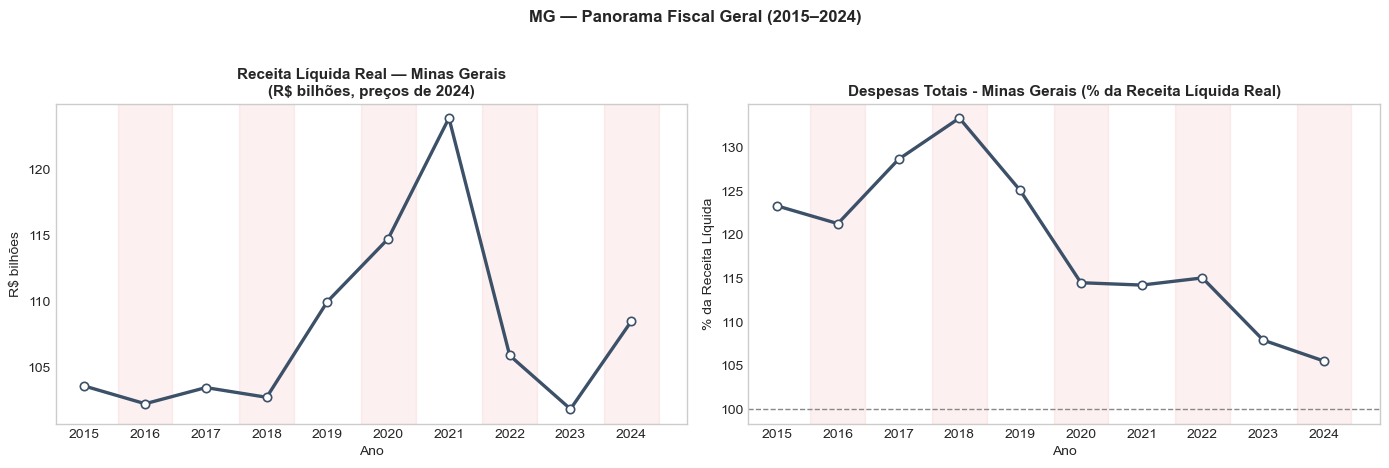

In [14]:
# =============================================================== #
# ===  VISÃO GERAL — PANORAMA FISCAL GERAL (MG, 2015–2024)   === #
# =============================================================== #

plt.style.use("seaborn-v0_8-whitegrid")

# === Base ===
df = tabela_liq.copy()
df["ano"] = df["ano"].astype(int)
df = df.set_index("ano").sort_index()

# --- (i) Receita Líquida real (R$ bi)
df["Rec_real_bi"] = df["Rec_real"] / 1e9

# --- (ii) Total das Despesas (% da Receita Líquida)
df["Total_%RL"] = df["TOTAL_GERAL_ID_%RecLiq"]

# --- Anos eleitorais (municipais + gerais)
eleicoes = [2016, 2018, 2020, 2022, 2024]
cor_eleicao = "#E84545"

# ==========================================================
# === PAINEL COM DOIS GRÁFICOS LADO A LADO (1x2) === #
# ==========================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 4.5))
fig.subplots_adjust(wspace=0.25)  # espaçamento horizontal entre os gráficos

# ----------------------------------------------------------
# GRÁFICO 1 — Receita Líquida Real (R$ bilhões)
# ----------------------------------------------------------
ax1 = axes[0]
ax1.set_facecolor("white")
ax1.grid(False)

for a in eleicoes:
    ax1.axvspan(a - 0.45, a + 0.45, color=cor_eleicao, alpha=0.08, zorder=0)

ax1.plot(df.index, df["Rec_real_bi"], color="#3C5068", linewidth=2.4, marker="o",
         markerfacecolor="white", markeredgewidth=1.2)

ax1.set_title("Receita Líquida Real — Minas Gerais\n(R$ bilhões, preços de 2024)",
              fontsize=11, weight="bold")
ax1.set_ylabel("R$ bilhões")
ax1.set_xlabel("Ano")
ax1.set_xticks(df.index)

# ----------------------------------------------------------
# GRÁFICO 2 — Total das Despesas (% da RL Real)
# ----------------------------------------------------------
ax2 = axes[1]
ax2.set_facecolor("white")
ax2.grid(False)

for a in eleicoes:
    ax2.axvspan(a - 0.45, a + 0.45, color=cor_eleicao, alpha=0.08, zorder=0)

ax2.plot(df.index, df["Total_%RL"], color="#3C5068", linewidth=2.4, marker="o",
         markerfacecolor="white", markeredgewidth=1.2, zorder=2)

ax2.axhline(100, color="#888888", linestyle="--", linewidth=1, zorder=1)

ax2.set_title("Despesas Totais - Minas Gerais (% da Receita Líquida Real)",
              fontsize=11, weight="bold")
ax2.set_ylabel("% da Receita Líquida")
ax2.set_xlabel("Ano")
ax2.set_xticks(df.index)

# ----------------------------------------------------------
# TÍTULO GERAL E AJUSTE FINAL
# ----------------------------------------------------------
fig.suptitle("MG — Panorama Fiscal Geral (2015–2024)", fontsize=12, weight="bold", y=1.03)
plt.tight_layout()
plt.show()


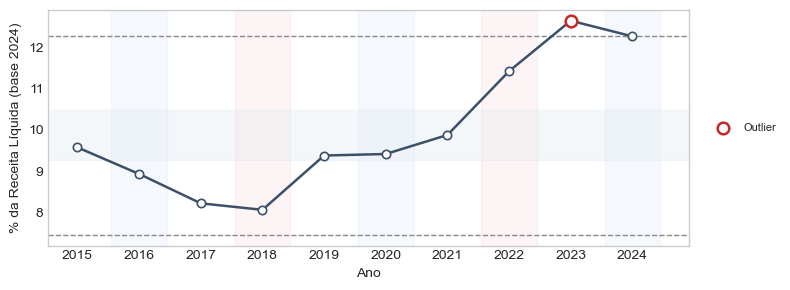

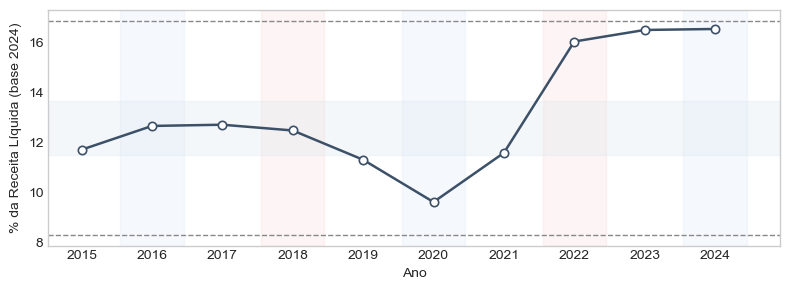

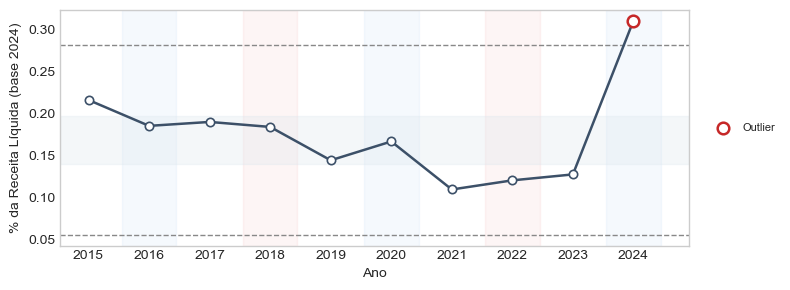

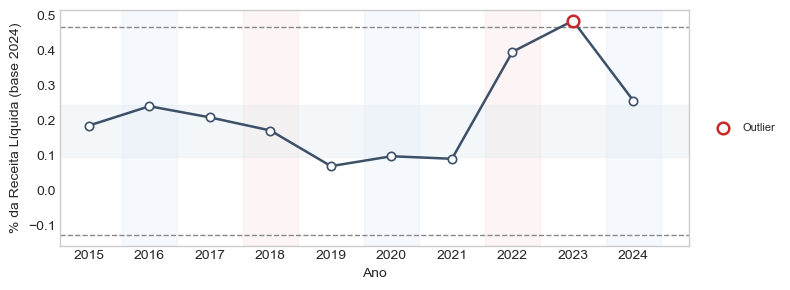

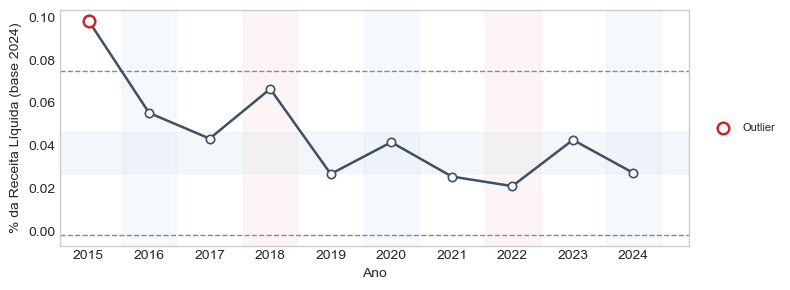

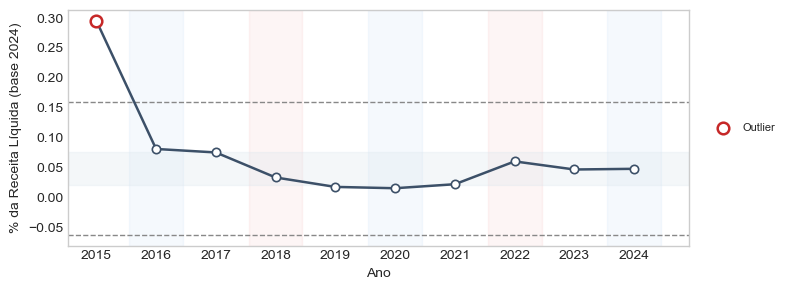

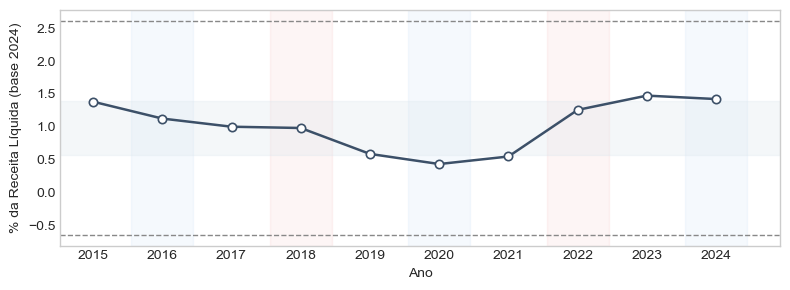

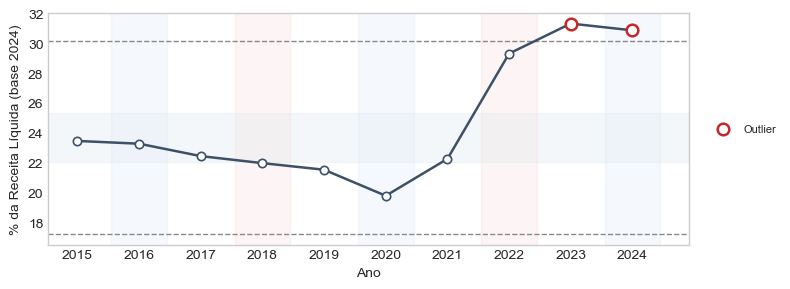

In [15]:
#========================================#
#== DESCRITIVA: OUTLIERS/SÉRIE TEMPORAL==#
#========================================#

plt.style.use("seaborn-v0_8-whitegrid")

# ----------------------------------------
# Anos eleitorais
# ----------------------------------------
eleicoes_estaduais = {2018, 2022}
eleicoes_municipais = {2016, 2020, 2024}

# ----------------------------------------
# Funções específicas (% da Receita Líquida)
# ----------------------------------------
funcoes_basicas = [
    "SAUDE_liq_%RecLiq", "EDUCACAO_liq_%RecLiq", "COMUNICACAO_liq_%RecLiq",
    "URBANISMO_liq_%RecLiq", "HABITACAO_liq_%RecLiq", "SANEAMENTO_liq_%RecLiq",
    "TRANSPORTE_liq_%RecLiq"
]

# ----------------------------------------
# Base
# ----------------------------------------
matriz = tabela_liq.copy()
matriz["ano"] = matriz["ano"].astype(int)
matriz = matriz.set_index("ano").sort_index()

# Cria coluna de total apenas das 7 funções
matriz["TOTAL_FUNCOES_SELECIONADAS_%RecLiq"] = matriz[funcoes_basicas].sum(axis=1, skipna=True)

# Nova lista para loop: sete funções + total selecionado
funcoes = funcoes_basicas + ["TOTAL_FUNCOES_SELECIONADAS_%RecLiq"]

# ---- IQR robusto: calcula limites usando só anos NÃO eleitorais
def outlier_mask_nao_eleitoral(df, col, anos_eleitorais):
    s = df[col].astype(float)
    base = s[~s.index.isin(anos_eleitorais)]
    if base.dropna().shape[0] < 4:
        return pd.Series(False, index=s.index)
    q1, q3 = base.quantile(0.25), base.quantile(0.75)
    iqr = q3 - q1
    lim_inf, lim_sup = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    return (s < lim_inf) | (s > lim_sup)

# ----------------------------------------
# Loop principal
# ----------------------------------------
for col in funcoes:
    s = matriz[col].astype(float)
    base = s[~s.index.isin(eleicoes_estaduais)]
    if base.dropna().shape[0] < 4:
        continue

    # limites IQR
    q1, q3 = base.quantile(0.25), base.quantile(0.75)
    iqr = q3 - q1
    lim_inf, lim_sup = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    mask_out = (s < lim_inf) | (s > lim_sup)
    anos_out = list(s.index[mask_out])
    anos_eleitorais_out = [a for a in anos_out if a in eleicoes_estaduais]

    # --- Plot ---
    fig, ax = plt.subplots(figsize=(8, 3))
    ax.set_facecolor("white")
    ax.grid(False)

    # Sombreamento anos eleitorais estaduais (vermelho claro)
    for a in sorted(eleicoes_estaduais):
        ax.axvspan(a - 0.45, a + 0.45, color="#E84545", alpha=0.05, zorder=0)

    # Sombreamento anos eleitorais municipais (azul muito claro)
    for a in sorted(eleicoes_municipais):
        ax.axvspan(a - 0.45, a + 0.45, color="#0066CC", alpha=0.04, zorder=0)

    # Faixa interquartil
    ax.axhspan(q1, q3, color="#DCE6EE", alpha=0.3, zorder=0)
    ax.axhline(lim_sup, color="#888", linestyle="--", linewidth=1)
    ax.axhline(lim_inf, color="#888", linestyle="--", linewidth=1)

    # Linha principal
    ax.plot(
        s.index, s, marker="o", color="#3C5068", linewidth=1.8,
        markerfacecolor="white", markeredgewidth=1.2
    )

    # Outliers
    if anos_out:
        ax.scatter(
            anos_out, s.loc[anos_out], s=70, facecolors="white",
            edgecolors="#C62828", linewidths=1.8, zorder=3, label="Outlier"
        )

    # Títulos removidos conforme solicitado
    ax.set_ylabel("% da Receita Líquida (base 2024)")
    ax.set_xlabel("Ano")
    ax.set_xticks(s.index)

    if anos_out:
        ax.legend(frameon=False, fontsize=8, loc="center left", bbox_to_anchor=(1.02, 0.5))

    plt.tight_layout()
    plt.show()



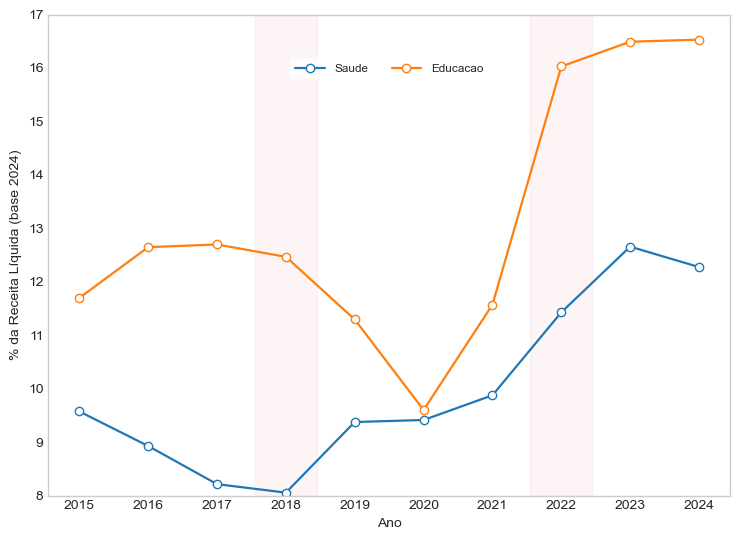

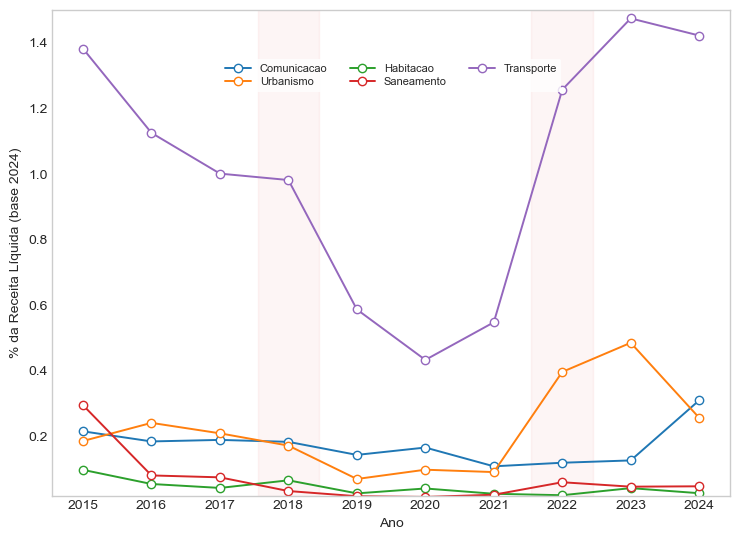

In [16]:
# ============================================================#
#== DESCRITIVA: OUTLIERS / SÉRIE TEMPORAL (DOIS GRÁFICOS) ====#
#============================================================#

plt.style.use("seaborn-v0_8-whitegrid")

# ----------------------------------------
# Anos eleitorais (estaduais/federais)
# ----------------------------------------
eleicoes_estaduais = {2018, 2022}

# ----------------------------------------
# Base
# ----------------------------------------
matriz = tabela_liq.copy()
matriz["ano"] = matriz["ano"].astype(int)
matriz = matriz.set_index("ano").sort_index()


# ============================================================#
# === GRUPO A — Saúde e Educação (8–17%)
# ============================================================#
funcoes_A = ["SAUDE_liq_%RecLiq", "EDUCACAO_liq_%RecLiq"]

fig, ax = plt.subplots(figsize=(7.5, 5.5))  # formato mais quadrado
ax.set_facecolor("white")
ax.grid(False)

# --- Sombreamento dos anos eleitorais
for a in sorted(eleicoes_estaduais):
    ax.axvspan(a - 0.45, a + 0.45, color="#E84545", alpha=0.05, zorder=0)

# --- Linhas das funções
for col in funcoes_A:
    s = matriz[col].astype(float)
    ax.plot(
        s.index, s, marker="o", linewidth=1.6,
        label=col.replace("_liq_%RecLiq", "").title(),
        markerfacecolor="white", markeredgewidth=1.0
    )

# --- Configurações visuais
ax.set_ylim(8, 17)
ax.set_ylabel("% da Receita Líquida (base 2024)")
ax.set_xlabel("Ano")
ax.set_xticks(matriz.index)

# --- Legenda interna (central superior)
ax.legend(
    frameon=True, fontsize=8.5, loc="upper center",
    bbox_to_anchor=(0.5, 0.92), ncol=2, facecolor="white",
    edgecolor="none", labelspacing=0.4, handlelength=2.5
)


plt.tight_layout()
plt.savefig("grafico_grupoA_quadrado.png", dpi=300, bbox_inches="tight")
plt.show()


# ============================================================#
# === GRUPO B — Comunicação, Urbanismo, Habitação, Saneamento, Transporte
# ============================================================#
funcoes_B = [
    "COMUNICACAO_liq_%RecLiq", "URBANISMO_liq_%RecLiq",
    "HABITACAO_liq_%RecLiq", "SANEAMENTO_liq_%RecLiq",
    "TRANSPORTE_liq_%RecLiq"
]

fig, ax = plt.subplots(figsize=(7.5, 5.5))  # mesmo formato equilibrado
ax.set_facecolor("white")
ax.grid(False)

# --- Sombreamento dos anos eleitorais
for a in sorted(eleicoes_estaduais):
    ax.axvspan(a - 0.45, a + 0.45, color="#E84545", alpha=0.05, zorder=0)

# --- Linhas das funções
for col in funcoes_B:
    s = matriz[col].astype(float)
    ax.plot(
        s.index, s, marker="o", linewidth=1.4,
        label=col.replace("_liq_%RecLiq", "").title(),
        markerfacecolor="white", markeredgewidth=1.0
    )

# --- Configurações visuais
ax.set_ylim(0.02, 1.5)
ax.set_ylabel("% da Receita Líquida (base 2024)")
ax.set_xlabel("Ano")
ax.set_xticks(matriz.index)

# --- Legenda interna (superior central)
ax.legend(
    frameon=True, fontsize=8, loc="upper center",
    bbox_to_anchor=(0.5, 0.91), ncol=3, facecolor="white",
    edgecolor="none", labelspacing=0.3, handlelength=2.3
)


plt.tight_layout()
plt.savefig("grafico_grupoB_quadrado.png", dpi=300, bbox_inches="tight")
plt.show()




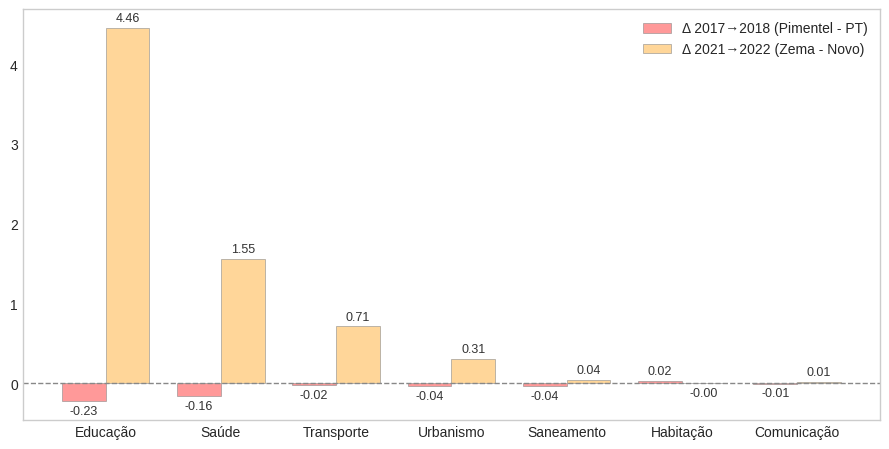

In [ ]:
# ====================================================== #
# === GRÁFICO: Δ PRÉ→ELEIÇÃO POR FUNÇÃO (Pimentel vs Zema) === #
# ====================================================== #

# -------- Base e segurança --------
df = tabela_liq.copy()
df["ano"] = df["ano"].astype(int)
df = df.set_index("ano").sort_index()

fun_cols_all = [
    "SAUDE_liq_%RecLiq","EDUCACAO_liq_%RecLiq","COMUNICACAO_liq_%RecLiq",
    "URBANISMO_liq_%RecLiq","HABITACAO_liq_%RecLiq","SANEAMENTO_liq_%RecLiq",
    "TRANSPORTE_liq_%RecLiq"
]
fun_cols = [c for c in fun_cols_all if c in df.columns]  # só as que existem

# pares pré→eleição
PRE_PT, ELEI_PT = 2017, 2018
PRE_ZE, ELEI_ZE = 2021, 2022

# função para calcular Δ com proteção
def delta_pre_eleicao(col, pre, elei):
    try:
        if pre in df.index and elei in df.index:
            return float(df.loc[elei, col] - df.loc[pre, col])
    except Exception:
        pass
    return np.nan

linhas = []
nome_map = {
    "SAUDE_liq_%RecLiq": "Saúde",
    "EDUCACAO_liq_%RecLiq": "Educação",
    "COMUNICACAO_liq_%RecLiq": "Comunicação",
    "URBANISMO_liq_%RecLiq": "Urbanismo",
    "HABITACAO_liq_%RecLiq": "Habitação",
    "SANEAMENTO_liq_%RecLiq": "Saneamento",
    "TRANSPORTE_liq_%RecLiq": "Transporte",
}

for c in fun_cols:
    d_pt = delta_pre_eleicao(c, PRE_PT, ELEI_PT)
    d_ze = delta_pre_eleicao(c, PRE_ZE, ELEI_ZE)
    linhas.append([nome_map.get(c, c), d_pt, d_ze])

delta_fun = pd.DataFrame(linhas, columns=["Função","Δ 2017→2018 (PT) [pp]","Δ 2021→2022 (Zema) [pp]"])

# ordenar por magnitude média dos bumps (para leitura)
delta_fun["ord"] = (delta_fun[["Δ 2017→2018 (PT) [pp]","Δ 2021→2022 (Zema) [pp]"]].abs()).mean(axis=1)
delta_fun = delta_fun.sort_values("ord", ascending=False).drop(columns="ord").reset_index(drop=True)

# -------- Plot: barras agrupadas --------
labels = delta_fun["Função"].tolist()
pt_vals = delta_fun["Δ 2017→2018 (PT) [pp]"].to_numpy()
ze_vals = delta_fun["Δ 2021→2022 (Zema) [pp]"].to_numpy()

x = np.arange(len(labels))
width = 0.38

fig, ax = plt.subplots(figsize=(9, 4.6))
ax.set_facecolor("white")
ax.grid(False)

# cores coerentes com seus gráficos anteriores
cor_pt   = "#FF9999"   # vermelho suave (PT)
cor_zema = "#FFD699"   # laranja suave (Zema)

b1 = ax.bar(x - width/2, pt_vals, width, label="Δ 2017→2018 (Pimentel - PT)", color=cor_pt, edgecolor="#8A8A8A", linewidth=0.4)
b2 = ax.bar(x + width/2, ze_vals, width, label="Δ 2021→2022 (Zema - Novo)", color=cor_zema, edgecolor="#8A8A8A", linewidth=0.4)

# linha zero (referência)
ax.axhline(0, color="#888888", linewidth=1, linestyle="--")

# rótulos e título

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=0)

# anotações nas barras
def annotate_bars(bars):
    for bar in bars:
        h = bar.get_height()
        if np.isnan(h):
            continue
        pos = h + (0.05 if h >= 0 else -0.05)
        ax.text(bar.get_x() + bar.get_width()/2, pos, f"{h:.2f}",
                ha="center", va="bottom" if h>=0 else "top", fontsize=9, color="#333333")

annotate_bars(b1)
annotate_bars(b2)

# legenda
ax.legend(frameon=False, loc="upper right")

plt.tight_layout()
plt.show()




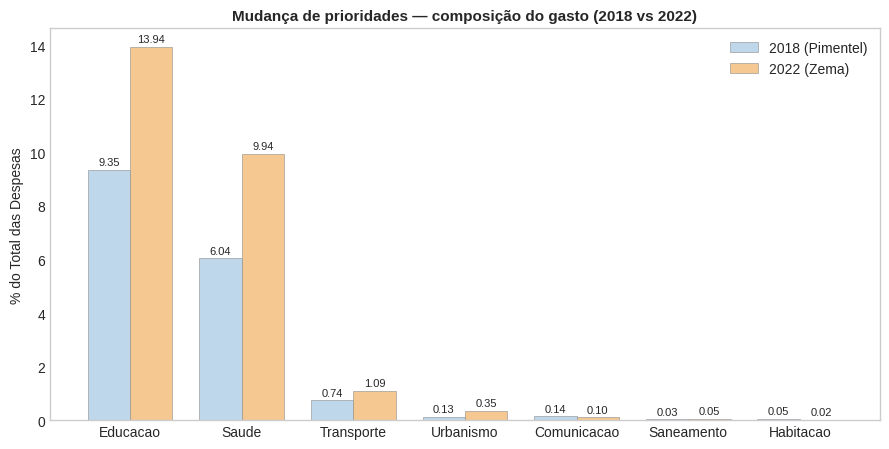

In [ ]:
# ================= COMPOSIÇÃO: 2018 vs 2022 (% do total das despesas) =================

df = tabela_liq.copy()
df["ano"] = df["ano"].astype(int)
df = df.set_index("ano").sort_index()

fun_cols = [c for c in [
    "SAUDE_liq_%RecLiq","EDUCACAO_liq_%RecLiq","COMUNICACAO_liq_%RecLiq",
    "URBANISMO_liq_%RecLiq","HABITACAO_liq_%RecLiq","SANEAMENTO_liq_%RecLiq",
    "TRANSPORTE_liq_%RecLiq"
] if c in df.columns]

tot = df["TOTAL_GERAL_ID_%RecLiq"]

def shares(ano):
    # share no total das despesas = (função %RL) / (total %RL) * 100
    s = {}
    for c in fun_cols:
        if ano in df.index and not pd.isna(df.loc[ano, c]) and not pd.isna(tot.loc[ano]) and tot.loc[ano] != 0:
            s[c] = (df.loc[ano, c] / tot.loc[ano]) * 100
        else:
            s[c] = np.nan
    return pd.Series(s)

sh18 = shares(2018)
sh22 = shares(2022)

plot_df = pd.DataFrame({
    "Função": [c.replace("_liq_%RecLiq","").title() for c in fun_cols],
    "2018": sh18.values,
    "2022": sh22.values
}).dropna().set_index("Função").sort_values("2022", ascending=False)

x = np.arange(len(plot_df))
w = 0.38

fig, ax = plt.subplots(figsize=(9, 4.6))
ax.set_facecolor("white"); ax.grid(False)
ax.bar(x - w/2, plot_df["2018"], width=w, color="#BFD7EA", edgecolor="#8A8A8A", linewidth=0.4, label="2018 (Pimentel)")
ax.bar(x + w/2, plot_df["2022"], width=w, color="#F5C892", edgecolor="#8A8A8A", linewidth=0.4, label="2022 (Zema)")
ax.set_xticks(x); ax.set_xticklabels(plot_df.index, rotation=0)
ax.set_ylabel("% do Total das Despesas")
ax.set_title("Mudança de prioridades — composição do gasto (2018 vs 2022)", fontsize=11, weight="bold")
ax.legend(frameon=False, loc="upper right")

# anota valores
for i, v in enumerate(plot_df["2018"]):
    if not np.isnan(v): ax.text(i - w/2, v + 0.1, f"{v:.2f}", ha="center", va="bottom", fontsize=8)
for i, v in enumerate(plot_df["2022"]):
    if not np.isnan(v): ax.text(i + w/2, v + 0.1, f"{v:.2f}", ha="center", va="bottom", fontsize=8)

plt.tight_layout(); plt.show()



# BLOCO 3 — ANÁLISE EM PAINEL DOS CICLOS OPORTUNISTAS

## 3.1 — Estrutura do Modelo e Hipótese de Interesse

Nesta etapa inicia-se a análise **econométrica dos ciclos político-orçamentários de natureza oportunista**.  

O objetivo é verificar empiricamente se **governadores estaduais elevam ou realocam despesas em funções mais visíveis ao eleitorado** nos períodos que antecedem e coincidem com as eleições estaduais — independentemente de fundamentos fiscais ou necessidades técnicas.

---





# 3.2 — Painel, Cobertura e Seleção da Amostra

Usaremos um **painel UF–Ano (2015–2024)**. Como é comum em finanças públicas, podem existir **lacunas** (anos sem informação para alguma função). Painéis **desbalanceados** são válidos em modelos com efeitos fixos, mas precisamos de **cobertura mínima** para comparar períodos eleitorais.

**Variáveis essenciais:**
- **ID:** `uf`, `ano`
- **Denominador fiscal:** `RL_real` (receita líquida deflacionada)
- **Variáveis dependentes (uma por regressão):**  
  `SAUDE_liq_%RecLiq`, `EDUCACAO_liq_%RecLiq`, `COMUNICACAO_liq_%RecLiq`,  
  `URBANISMO_liq_%RecLiq`, `HABITACAO_liq_%RecLiq`, `SANEAMENTO_liq_%RecLiq`, `TRANSPORTE_liq_%RecLiq`

**Regra de elegibilidade (mínima e justificável):**
1) **Cobertura temporal mínima:** pelo menos **8 anos** no período 2015–2024 (qualquer combinação).  
2) **Janelas eleitorais presentes:** pelo menos **2 observações** em **cada** bloco:
   - Bloco 2017–2019 (pré 2018, eleição 2018, pós 2019)  
   - Bloco 2021–2023 (pré 2021, eleição 2022, pós 2023)  
   > Racional: conseguimos comparar comportamento em torno de **ambas** eleições estaduais (2018 e 2022).

3) **Integridade das variáveis-alvo:** para cada função estimada, a UF precisa ter observações nessa função que atendam (1) e (2).  
   > Ou seja, a lista de UFs elegíveis pode mudar **por função**.

Com isso, mantemos o painel utilizável (não jogamos fora tudo por poucos buracos) e preservamos a **comparabilidade** necessária nos momentos eleitorais.


In [ ]:
# @title
# ============================================================ #
# === BLOCO: CONSTRUÇÃO DO PAINEL NACIONAL (TODAS AS UFs) === #
# ============================================================ #

# --- Parâmetros e leitura base ---
CSV_DCA = "dca_estados_2015_2025.csv"
deflatores = pd.read_csv("deflatores_ipca_2015_2025.csv")

FUNCOES = {
    "SAUDE": "10",
    "EDUCACAO": "12",
    "COMUNICACAO": "13",
    "URBANISMO": "15",
    "HABITACAO": "16",
    "SANEAMENTO": "17",
    "TRANSPORTE": "26",
}

# --- Leitura e normalização do CSV bruto do SICONFI ---
df_all = pd.read_csv(CSV_DCA)
df_all.columns = [c.strip().lower() for c in df_all.columns]

for c in ["uf", "anexo", "coluna", "conta"]:
    df_all[c] = df_all[c].astype(str).str.upper().str.strip()
df_all["ano"] = pd.to_numeric(df_all["ano"], errors="coerce").astype("Int64")
df_all["valor_num"] = pd.to_numeric(df_all["valor"], errors="coerce")

# --- Funções auxiliares (iguais às do bloco MG) ---
def norm(s: str) -> str:
    s = (s or "").upper()
    return (s.replace("Á", "A").replace("Â", "A").replace("Ã", "A")
             .replace("É", "E").replace("Ê", "E")
             .replace("Í", "I").replace("Ó", "O").replace("Õ", "O")
             .replace("Ú", "U").replace("Ç", "C"))

def processar_despesas(df_ref: pd.DataFrame, uf: str, coluna_alvo: str) -> pd.DataFrame:
    base = df_ref[
        (df_ref["uf"] == uf)
        & (df_ref["coluna"].str.contains(coluna_alvo.upper(), na=False))
    ].copy()

    if base.empty:
        return pd.DataFrame()

    ie = base[base["anexo"].str.contains("I-E", case=False, na=False)].copy()
    if ie.empty:
        return pd.DataFrame()

    ie["conta_n"]   = ie["conta"].map(norm)
    ie["cod_func"]  = ie["conta_n"].str.extract(r"^\s*(\d{2})")[0]
    ie["is_funcao"] = ie["conta_n"].str.match(r"^\s*(10|12|13|15|16|17|26)\s*-\s+[A-Z ]+$")
    ie["is_sub"]    = ie["conta_n"].str.match(r"^\s*(10|12|13|15|16|17|26)\.\d+\s*-\s+")

    anos = sorted(ie["ano"].dropna().unique())
    series = {}
    for nome, cod in FUNCOES.items():
        sub = ie[ie["cod_func"] == cod]
        fun_top = sub[sub["is_funcao"]].groupby("ano")["valor_num"].sum()
        fun_sub = sub[sub["is_sub"]].groupby("ano")["valor_num"].sum()
        series[nome] = pd.Series(
            [fun_top.get(a, fun_sub.get(a, np.nan)) for a in anos],
            index=anos, name=nome
        )

    matriz = pd.DataFrame(series, index=anos).sort_index()
    matriz["TOTAL_FUNCOES_IE"] = matriz.sum(axis=1, skipna=True)

    # total geral (I-D)
    id_ = base[base["anexo"].str.contains("I-D", case=False, na=False)].copy()
    if not id_.empty:
        id_total = id_[id_["conta"].str.upper().str.contains("TOTAL GERAL", na=False)]
        if not id_total.empty:
            tot_id = id_total.groupby("ano")["valor_num"].sum().rename("TOTAL_GERAL_ID")
            matriz = matriz.join(tot_id, how="left")

    return matriz


def processar_receita_liquida(df_ref: pd.DataFrame, uf: str) -> pd.DataFrame:
    CONTA_NIVEIS = ["1.0.0.0.00.0.0", "1.0.0.0.00.00.00"]
    base = df_ref[
        (df_ref["uf"] == uf)
        & (df_ref["anexo"].str.contains("I-C", case=False, na=False))
    ].copy()
    if base.empty:
        return pd.DataFrame()

    mask_conta = base["conta"].apply(lambda x: any(str(x).startswith(c) for c in CONTA_NIVEIS))
    base_nivel = base[mask_conta].copy()

    mask_bruta = base_nivel["coluna"].str.contains("RECEITAS BRUTAS", na=False)
    receita_bruta = base_nivel[mask_bruta].groupby("ano")["valor_num"].sum()

    mask_deduc = (
        base_nivel["coluna"].str.startswith("DEDUÇÕES", na=False)
        | base_nivel["coluna"].str.contains("OUTRAS DEDUÇÕES", na=False)
    )
    deducoes_totais = base_nivel[mask_deduc].groupby("ano")["valor_num"].sum()

    rec_liq = pd.DataFrame({
        "Receita_Liquida": receita_bruta - deducoes_totais
    })
    return rec_liq


# --- Loop principal por UF ---
bases = []
for uf in sorted(df_all["uf"].unique()):
    try:
        matriz_liq = processar_despesas(df_all, uf, "Despesas Liquidadas")
        rec_liq = processar_receita_liquida(df_all, uf)
        if matriz_liq.empty or rec_liq.empty:
            print(f"{uf}: dados insuficientes (I-E/I-D/I-C ausentes)")
            continue

        df_uf = pd.merge(matriz_liq.reset_index().rename(columns={"index": "ano"}),
                         rec_liq.reset_index(), on="ano", how="left")
        df_uf = pd.merge(df_uf, deflatores[["ano", "deflator_base2024"]], on="ano", how="left")
        df_uf = df_uf.dropna(subset=["Receita_Liquida", "deflator_base2024"]).copy()

        # Deflaciona
        for c in [*FUNCOES.keys(), "TOTAL_FUNCOES_IE", "TOTAL_GERAL_ID", "Receita_Liquida"]:
            if c in df_uf.columns:
                df_uf[f"{c}_real"] = df_uf[c] / df_uf["deflator_base2024"]

        df_uf["RL_real"] = df_uf["Receita_Liquida_real"]

        # Normaliza (%RL)
        for f in FUNCOES.keys():
            col = f"{f}_real"
            if col in df_uf.columns:
                df_uf[f"{f}_liq_%RecLiq"] = (df_uf[col] / df_uf["RL_real"]) * 100

        df_uf["uf"] = uf
        out_cols = ["uf", "ano", "RL_real"] + [f"{f}_liq_%RecLiq" for f in FUNCOES.keys()]
        bases.append(df_uf[out_cols])
        print(f"{uf}: OK ({df_uf.shape[0]} anos)")
    except Exception as e:
        print(f"{uf}: falhou — {e}")

# --- Concatena painel ---
if len(bases) == 0:
    raise ValueError("Nenhuma UF processada. Verifique se o CSV contém I-E, I-D e I-C.")
painel = pd.concat(bases, ignore_index=True).sort_values(["uf", "ano"]).reset_index(drop=True)

print("\nPainel consolidado:")
print(painel.head(10))
print(f"\nTotal: {painel['uf'].nunique()} UFs | {painel['ano'].nunique()} anos | {painel.shape[0]} linhas")

painel.to_csv("painel_funcoes_2015_2024.csv", index=False, encoding="utf-8-sig")
print("\nArquivo salvo: painel_funcoes_2015_2024.csv")



AC: OK (10 anos)
AL: OK (10 anos)
AM: OK (10 anos)
AP: OK (10 anos)
BA: OK (10 anos)
CE: OK (10 anos)
DF: OK (10 anos)
ES: OK (10 anos)
GO: OK (10 anos)
MA: OK (10 anos)
MG: OK (10 anos)
MS: OK (10 anos)
MT: OK (10 anos)
PA: OK (10 anos)
PB: OK (10 anos)
PE: OK (10 anos)
PI: OK (10 anos)
PR: OK (10 anos)
RJ: OK (10 anos)
RN: OK (10 anos)
RO: OK (10 anos)
RR: OK (10 anos)
RS: OK (10 anos)
SC: OK (10 anos)
SE: OK (10 anos)
SP: OK (2 anos)
TO: OK (10 anos)

Painel consolidado:
   uf   ano       RL_real  SAUDE_liq_%RecLiq  EDUCACAO_liq_%RecLiq  \
0  AC  2015  6.973078e+09          16.806326             21.526862   
1  AC  2016  7.324930e+09          15.502636             20.139073   
2  AC  2017  7.255453e+09          16.088064             22.502712   
3  AC  2018  7.695895e+09          15.754927             23.607935   
4  AC  2019  8.076080e+09          13.933545             21.951942   
5  AC  2020  8.111432e+09          17.267201             18.898801   
6  AC  2021  8.624265e+09      

In [ ]:
# ==============================================================
# NORMALIZAÇÃO DO PAINEL DO PAINEL — ELIGIBILIDADE
# ==============================================================

CSV_PAINEL = "painel_funcoes_2015_2024.csv"
df = pd.read_csv(CSV_PAINEL)
print("Base carregada:", df.shape)
print(df.columns.tolist(), "\n")

ID_COLS   = ["uf", "ano"]
DENOM_COL = "RL_real"
FUNCOES   = [
    "SAUDE_liq_%RecLiq", "EDUCACAO_liq_%RecLiq", "COMUNICACAO_liq_%RecLiq",
    "URBANISMO_liq_%RecLiq", "HABITACAO_liq_%RecLiq",
    "SANEAMENTO_liq_%RecLiq", "TRANSPORTE_liq_%RecLiq"
]
ANOS_FULL = list(range(2015, 2025))
BLOCO_18  = {2017, 2018, 2019}
BLOCO_22  = {2021, 2022, 2023}

os.makedirs("diagnosticos", exist_ok=True)


def sanitize_panel(df):
    out = df.copy()
    out.columns = [c.strip() for c in out.columns]
    out = out[ID_COLS + [DENOM_COL] + FUNCOES].drop_duplicates(subset=ID_COLS)
    out["ano"] = out["ano"].astype(int)
    out = out[out["ano"].between(min(ANOS_FULL), max(ANOS_FULL))]
    out = out.sort_values(ID_COLS).reset_index(drop=True)
    return out

# ------------------------------------------------------------
# Diagnóstico de missing (proporção de NaN)
# ------------------------------------------------------------
def missing_report(df):
    summary = (
        df.groupby("uf")[FUNCOES + [DENOM_COL]]
        .apply(lambda x: x.isna().mean())
        .rename_axis("uf")
    )
    summary["total_missing_share"] = summary.mean(axis=1)
    return summary.sort_values("total_missing_share", ascending=False)


def eligible_states_by_function(df, func_col, min_total=8):
    sub = df[["uf", "ano", DENOM_COL, func_col]].copy()

    sub["has_func"] = sub[func_col].notna().astype(int)
    sub["has_RL"] = sub[DENOM_COL].notna().astype(int)

    grp = sub.groupby("uf")
    total_years = grp["has_func"].sum()
    has_RL_any = grp["has_RL"].sum() > 0
    in_18 = sub[sub["ano"].isin(BLOCO_18)].groupby("uf")["has_func"].sum()
    in_22 = sub[sub["ano"].isin(BLOCO_22)].groupby("uf")["has_func"].sum()

    ufs = sorted(sub["uf"].unique())
    total_years = total_years.reindex(ufs, fill_value=0)
    has_RL_any = has_RL_any.reindex(ufs, fill_value=False)
    in_18 = in_18.reindex(ufs, fill_value=0)
    in_22 = in_22.reindex(ufs, fill_value=0)

    ok = (
        (total_years >= min_total)
        & (in_18 >= 2)
        & (in_22 >= 2)
        & (has_RL_any)
    )

    diag = pd.DataFrame({
        "uf": ufs,
        "obs_func_total": total_years.values,
        "obs_bloc_2017_2019": in_18.values,
        "obs_bloc_2021_2023": in_22.values,
        "has_RL_any": has_RL_any.values,
        "eligible": ok.values
    }).sort_values(["eligible", "uf"], ascending=[False, True])

    eligible = diag.loc[diag["eligible"], "uf"].tolist()
    excluded = diag.loc[~diag["eligible"], "uf"].tolist()
    return diag, eligible, excluded


df_panel = sanitize_panel(df)
print(f"Painel: {df_panel['uf'].nunique()} UFs | "
      f"{df_panel['ano'].nunique()} anos ({df_panel.shape[0]} linhas)\n")

missing = missing_report(df_panel)
missing.to_csv("diagnosticos/missing_report.csv", encoding="utf-8-sig")
print("Top 10 UFs com maior proporção média de missing:")
print(missing.head(10), "\n")

elegiveis = {}
for func in FUNCOES:
    diag, ok, no = eligible_states_by_function(df_panel, func)
    elegiveis[func] = ok
    diag.to_csv(f"diagnosticos/eligibilidade_{func}.csv", index=False, encoding="utf-8-sig")

    print(f"Função: {func}")
    print(f"  UFs elegíveis ({len(ok)}): {sorted(ok)}")
    print(f"  Excluídas ({len(no)}): {sorted(no)}\n")
    print(diag.to_string(index=False))
    print("-" * 80)

# --- Salva lista consolidada de elegíveis ---
pd.DataFrame({
    "funcao": list(elegiveis.keys()),
    "ufs_elegiveis": [", ".join(v) for v in elegiveis.values()]
}).to_csv("diagnosticos/elegiveis_consolidado.csv", index=False, encoding="utf-8-sig")

print("\n Diagnóstico Consolidado 1 concluído.")
print("→ Relatórios salvos na pasta 'diagnosticos/'")


Base carregada: (262, 10)
['uf', 'ano', 'RL_real', 'SAUDE_liq_%RecLiq', 'EDUCACAO_liq_%RecLiq', 'COMUNICACAO_liq_%RecLiq', 'URBANISMO_liq_%RecLiq', 'HABITACAO_liq_%RecLiq', 'SANEAMENTO_liq_%RecLiq', 'TRANSPORTE_liq_%RecLiq'] 

Painel: 27 UFs | 10 anos (262 linhas)

Top 10 UFs com maior proporção média de missing:
    SAUDE_liq_%RecLiq  EDUCACAO_liq_%RecLiq  COMUNICACAO_liq_%RecLiq  \
uf                                                                     
RN                0.0                   0.0                      0.0   
SP                0.0                   0.0                      0.0   
RO                0.0                   0.0                      0.0   
PR                0.0                   0.0                      0.0   
GO                0.0                   0.0                      0.0   
MS                0.0                   0.0                      0.0   
SC                0.0                   0.0                      0.0   
AP                0.0                

In [ ]:
# ============================================================
# TRATAMENTO E DESCRITIVA DO PAINEL 1 — Winsorização
# ============================================================

CSV_PAINEL = "painel_funcoes_2015_2024.csv"
df = pd.read_csv(CSV_PAINEL)
df["ano"] = df["ano"].astype(int)
df["uf"] = df["uf"].str.upper().str.strip()

print(f"Base carregada: {df.shape}")
os.makedirs("diagnosticos", exist_ok=True)

funcoes = [
    "SAUDE_liq_%RecLiq", "EDUCACAO_liq_%RecLiq", "COMUNICACAO_liq_%RecLiq",
    "URBANISMO_liq_%RecLiq", "HABITACAO_liq_%RecLiq",
    "SANEAMENTO_liq_%RecLiq", "TRANSPORTE_liq_%RecLiq"
]


def winsorize_series(s, lower_q=0.01, upper_q=0.99):
    """
    Corta extremos em percentis (padrão 1%–99%) dentro da mesma UF×função.
    Mantém valores dentro do intervalo e limita extremos ao limiar.
    """
    if s.dropna().empty:
        return s
    q_low, q_high = s.quantile(lower_q), s.quantile(upper_q)
    return np.clip(s, q_low, q_high)


df_winsor = df.copy()
for col in funcoes:
    df_winsor[col] = (
        df_winsor.groupby("uf")[col]
        .transform(lambda x: winsorize_series(x, 0.01, 0.99))
    )


# (i) linhas onde TODAS as funções são nulas
mask_all_null = df_winsor[funcoes].isna().all(axis=1)
df_winsor = df_winsor.loc[~mask_all_null].copy()

# (ii) garantir presença de RL_real
df_winsor = df_winsor.dropna(subset=["RL_real"])

auditoria = []
for col in funcoes:
    diffs = (df[col] != df_winsor[col]) & df[col].notna()
    pct_alterado = diffs.mean() * 100
    auditoria.append({"funcao": col, "pct_ajustado": round(pct_alterado, 2)})
    if pct_alterado > 0:
        print(f"{col}: {pct_alterado:.2f}% dos valores ajustados pelos limites 1–99%")

auditoria_df = pd.DataFrame(auditoria)
auditoria_df.to_csv("diagnosticos/winsor_stats.csv", index=False, encoding="utf-8-sig")


print("\nResumo:")
print(f"Antes da winsorização: {df.shape}")
print(f"Após winsorização e remoção de nulos: {df_winsor.shape}")

OUTFILE = "painel_funcoes_2015_2024_winsor.csv"
df_winsor.to_csv(OUTFILE, index=False, encoding="utf-8-sig")

print(f"\nPainel ajustado salvo em: {OUTFILE}")
print("Relatório de auditoria salvo em: diagnosticos/winsor_stats.csv")

Base carregada: (262, 10)
SAUDE_liq_%RecLiq: 20.61% dos valores ajustados pelos limites 1–99%
EDUCACAO_liq_%RecLiq: 20.61% dos valores ajustados pelos limites 1–99%
COMUNICACAO_liq_%RecLiq: 20.61% dos valores ajustados pelos limites 1–99%
URBANISMO_liq_%RecLiq: 19.85% dos valores ajustados pelos limites 1–99%
HABITACAO_liq_%RecLiq: 20.61% dos valores ajustados pelos limites 1–99%
SANEAMENTO_liq_%RecLiq: 19.85% dos valores ajustados pelos limites 1–99%
TRANSPORTE_liq_%RecLiq: 20.61% dos valores ajustados pelos limites 1–99%

Resumo:
Antes da winsorização: (262, 10)
Após winsorização e remoção de nulos: (262, 10)

Painel ajustado salvo em: painel_funcoes_2015_2024_winsor.csv
Relatório de auditoria salvo em: diagnosticos/winsor_stats.csv


# 3.3 — Variáveis do ciclo e base pronta pro modelo

Racional: marcar **quando** estamos perto da eleição e controlar **quanto a receita real mudou** naquele ano. Com isso, a comparação “antes/durante/depois” da eleição fica limpa.

**Marcadores do ciclo (dummies):**
- `E_m1`: ano **pré-eleitoral** (2017, 2021)
- `E_0`: ano **eleitoral** (2018, 2022)
- `E_p1`: ano **pós-eleitoral** (2019, 2023)

**Controle fiscal:**
- `dlog_RL`: crescimento real da receita líquida no ano (`log(RL_t) − log(RL_{t−1})` por UF)

Depois disso, a gente roda **uma regressão por função** (Saúde, Educação etc.) com efeitos fixos de UF



In [ ]:
# ============================================================
# 3.3 — CONSTRUÇÃO DAS VARIÁVEIS E BASES PARA REGRESSÃO
# ============================================================

CSV_PAINEL = "painel_funcoes_2015_2024_winsor.csv"
df = pd.read_csv(CSV_PAINEL)
df["ano"] = df["ano"].astype(int)
df["uf"]  = df["uf"].str.upper().str.strip()
df = df.sort_values(["uf", "ano"]).reset_index(drop=True)

print(f"Base carregada: {df.shape}")

os.makedirs("modelos_ready", exist_ok=True)

df["E_m1"] = df["ano"].isin([2017, 2021]).astype(int)
df["E_0"]  = df["ano"].isin([2018, 2022]).astype(int)
df["E_p1"] = df["ano"].isin([2019, 2023]).astype(int)


df["dlog_RL"] = (
    df.groupby("uf")["RL_real"]
      .apply(lambda s: np.log(s).diff())
      .values
)


usar_elegiveis = True
PASTA_ELEG = "diagnosticos"
FUNCOES = [
    "SAUDE_liq_%RecLiq", "EDUCACAO_liq_%RecLiq", "COMUNICACAO_liq_%RecLiq",
    "URBANISMO_liq_%RecLiq", "HABITACAO_liq_%RecLiq",
    "SANEAMENTO_liq_%RecLiq", "TRANSPORTE_liq_%RecLiq"
]


elegiveis = {}
if usar_elegiveis:
    for f in FUNCOES:
        path = os.path.join(PASTA_ELEG, f"eligibilidade_{f}.csv")
        if os.path.exists(path):
            df_elig = pd.read_csv(path)
            ok = df_elig.loc[df_elig["eligible"] == True, "uf"].tolist()
            elegiveis[f] = ok
        else:
            elegiveis[f] = df["uf"].unique().tolist()  # fallback


bases_para_modelo = {}

for f in FUNCOES:
    base_f = df[["uf", "ano", f, "E_m1", "E_0", "E_p1", "dlog_RL"]].copy()

    if usar_elegiveis and f in elegiveis:
        base_f = base_f[base_f["uf"].isin(elegiveis[f])]

    # Remove linhas com y nulo
    base_f = base_f.dropna(subset=[f])

    # Salva em memória e em CSV
    bases_para_modelo[f] = base_f
    base_f.to_csv(f"modelos_ready/modelo_ready_{f}.csv", index=False, encoding="utf-8-sig")

# ------------------------------------------------------------
# 7) Resumo das bases criadas
# ------------------------------------------------------------
print("\nBases geradas para regressão (uma por função):")
resumo = []
for k, v in bases_para_modelo.items():
    resumo.append({
        "funcao": k,
        "UFs": v["uf"].nunique(),
        "Anos": v["ano"].nunique(),
        "Linhas": v.shape[0]
    })
    print(f"  - {k}: {v['uf'].nunique()} UFs, "
          f"{v['ano'].nunique()} anos, "
          f"{v.shape[0]} linhas -> arquivo: modelos_ready/modelo_ready_{k}.csv")

pd.DataFrame(resumo).to_csv("diagnosticos/modelos_ready_resumo.csv", index=False, encoding="utf-8-sig")

print("\nResumo salvo em: diagnosticos/modelos_ready_resumo.csv")
print("Etapa 3.3 concluída — bases prontas para regressão de painel.")

Base carregada: (262, 10)

Bases geradas para regressão (uma por função):
  - SAUDE_liq_%RecLiq: 26 UFs, 10 anos, 260 linhas -> arquivo: modelos_ready/modelo_ready_SAUDE_liq_%RecLiq.csv
  - EDUCACAO_liq_%RecLiq: 26 UFs, 10 anos, 260 linhas -> arquivo: modelos_ready/modelo_ready_EDUCACAO_liq_%RecLiq.csv
  - COMUNICACAO_liq_%RecLiq: 26 UFs, 10 anos, 260 linhas -> arquivo: modelos_ready/modelo_ready_COMUNICACAO_liq_%RecLiq.csv
  - URBANISMO_liq_%RecLiq: 24 UFs, 10 anos, 236 linhas -> arquivo: modelos_ready/modelo_ready_URBANISMO_liq_%RecLiq.csv
  - HABITACAO_liq_%RecLiq: 25 UFs, 10 anos, 248 linhas -> arquivo: modelos_ready/modelo_ready_HABITACAO_liq_%RecLiq.csv
  - SANEAMENTO_liq_%RecLiq: 23 UFs, 10 anos, 229 linhas -> arquivo: modelos_ready/modelo_ready_SANEAMENTO_liq_%RecLiq.csv
  - TRANSPORTE_liq_%RecLiq: 26 UFs, 10 anos, 260 linhas -> arquivo: modelos_ready/modelo_ready_TRANSPORTE_liq_%RecLiq.csv

Resumo salvo em: diagnosticos/modelos_ready_resumo.csv
Etapa 3.3 concluída — bases pron

In [ ]:
# ============================================================
# CONFERÊNCIA DE BALANCEAMENTO
# ============================================================

READY_DIR  = "modelos_ready"
OUT_DIR    = "diagnosticos/balanceamento"
ANOS_FULL  = list(range(2015, 2025))     # janela alvo
TMAX       = len(ANOS_FULL)
QBAL_MIN_T = int(0.9 * TMAX)             # critério "quase balanceado" (≥90%)

os.makedirs(OUT_DIR, exist_ok=True)

def conferencia_balanceamento(path_csv):
    df = pd.read_csv(path_csv)
    df["uf"] = df["uf"].str.upper().str.strip()
    df["ano"] = df["ano"].astype(int)

    # --- Cobertura por UF (T_i) e índice de desbalanceamento
    Ti = df.groupby("uf")["ano"].nunique().rename("Ti")
    imb = (1 - Ti / TMAX).rename("imb_indice")
    cobertura = pd.concat([Ti, imb], axis=1).reset_index()

    # --- Frações balanceado / quase-balanceado
    frac_bal  = (Ti == TMAX).mean()
    frac_qbal = (Ti >= QBAL_MIN_T).mean()

    # --- Lista de anos faltantes por UF
    grid = (df[["uf","ano"]]
            .drop_duplicates()
            .pivot_table(index="uf", columns="ano", values="ano", aggfunc="size")
            .reindex(columns=ANOS_FULL, fill_value=0))
    anos_faltantes = {
        uf: [a for a in ANOS_FULL if grid.loc[uf, a] == 0]
        for uf in grid.index
    }
    faltas = (pd.Series(anos_faltantes, name="anos_faltantes")
                .rename_axis("uf").reset_index())

    # --- Subpainéis (robustez)
    ufs_bal  = Ti[Ti == TMAX].index.tolist()
    ufs_qbal = Ti[Ti >= QBAL_MIN_T].index.tolist()
    sub_bal  = df[df["uf"].isin(ufs_bal)]
    sub_qbal = df[df["uf"].isin(ufs_qbal)]

    # --- Resumo numérico
    resumo = {
        "UFs": df["uf"].nunique(),
        "Anos_distintos": df["ano"].nunique(),
        "Linhas": df.shape[0],
        "TMAX": TMAX,
        "Ti_mediana": Ti.median(),
        "Ti_p5": Ti.quantile(0.05),
        "Ti_p95": Ti.quantile(0.95),
        "imb_media": imb.mean(),
        "imb_p90": imb.quantile(0.90),
        "frac_balanceado": frac_bal,
        "frac_quase_balanceado_90pct": frac_qbal
    }
    return cobertura, faltas, resumo, sub_bal, sub_qbal

# --- Roda para todas as funções prontas no 3.3
consol = []
for fname in os.listdir(READY_DIR):
    if not (fname.startswith("modelo_ready_") and fname.endswith(".csv")):
        continue
    func = fname.replace("modelo_ready_","").replace(".csv","")
    path = os.path.join(READY_DIR, fname)

    cobertura, faltas, resumo, sub_bal, sub_qbal = conferencia_balanceamento(path)

    # salva artefatos
    cobertura.to_csv(f"{OUT_DIR}/Ti_{func}.csv", index=False, encoding="utf-8-sig")
    faltas.to_csv(f"{OUT_DIR}/faltas_{func}.csv", index=False, encoding="utf-8-sig")
    sub_bal.to_csv(f"{READY_DIR}/modelo_ready_{func}_BAL.csv", index=False, encoding="utf-8-sig")
    sub_qbal.to_csv(f"{READY_DIR}/modelo_ready_{func}_QBAL.csv", index=False, encoding="utf-8-sig")

    # acumula resumo
    row = {"funcao": func, **resumo}
    consol.append(row)

# consolidado de funções
consol_df = pd.DataFrame(consol).sort_values(["imb_media","frac_balanceado"], ascending=[True, False])
consol_df.to_csv(f"{OUT_DIR}/consolidado_balanceamento.csv", index=False, encoding="utf-8-sig")
print(consol_df)
print(f"\nRelatórios em: {OUT_DIR} | Subpainéis salvos em: {READY_DIR} (sufixos _BAL / _QBAL)")


                               funcao  UFs  Anos_distintos  Linhas  TMAX  \
0              TRANSPORTE_liq_%RecLiq   26              10     260    10   
4          SAUDE_liq_%RecLiq_QBAL_BAL   26              10     260    10   
5      URBANISMO_liq_%RecLiq_QBAL_BAL   22              10     220    10   
7      SANEAMENTO_liq_%RecLiq_BAL_BAL   22              10     220    10   
8             COMUNICACAO_liq_%RecLiq   26              10     260    10   
9         TRANSPORTE_liq_%RecLiq_QBAL   26              10     260    10   
10        COMUNICACAO_liq_%RecLiq_BAL   26              10     260    10   
11             SAUDE_liq_%RecLiq_QBAL   26              10     260    10   
12    SANEAMENTO_liq_%RecLiq_QBAL_BAL   22              10     220    10   
13       EDUCACAO_liq_%RecLiq_BAL_BAL   26              10     260    10   
14     URBANISMO_liq_%RecLiq_BAL_QBAL   22              10     220    10   
15     TRANSPORTE_liq_%RecLiq_BAL_BAL   26              10     260    10   
16         U

# 3.4 — Estimação dos Ciclos Oportunistas
---
#### **Teste da Hipótese**


In [ ]:
# ============================================================
# TESTE BREUSCH–PAGAN LM
# ============================================================
# ------------------------------------------------------------
# 1. Carregar a base (já balanceada)
# ------------------------------------------------------------
func = "SAUDE_liq_%RecLiq"
path = f"modelos_ready/modelo_ready_{func}.csv"

df = pd.read_csv(path)
df["ano"] = df["ano"].astype(int)
df["uf"] = df["uf"].astype(str)
df = df.set_index(["uf", "ano"]).sort_index()

y = df[func]
X = sm.add_constant(df[["E_m1", "E_0", "E_p1", "dlog_RL"]])

n = df.index.get_level_values("uf").nunique()
T = df.index.get_level_values("ano").nunique()


ols_mod = PooledOLS(y, X).fit()
df["resid"] = ols_mod.resids


mean_resid_unit = df.groupby("uf")["resid"].mean()

# Variância entre unidades (σ²_u)
sigma_u2 = T * np.var(mean_resid_unit, ddof=1)

# Variância total dos resíduos (σ²_e + σ²_u)
sigma_total2 = np.var(df["resid"], ddof=1)

# Variância idiossincrática (σ²_e)
sigma_e2 = sigma_total2 - sigma_u2

# Correlação intraclasse
rho = sigma_u2 / (sigma_u2 + sigma_e2)

LM = (n * T / (2 * (T - 1))) * (rho ** 2)
pval = 1 - stats.chi2.cdf(LM, df=1)

print("\n=== TESTE BREUSCH–PAGAN LM (OLS vs RE) ===")
print(f"σ²_u (entre UFs): {sigma_u2:.6f}")
print(f"σ²_e (erro idiossincrático): {sigma_e2:.6f}")
print(f"ρ (intra-class correlation): {rho:.4f}")
print(f"LM estatística: {LM:.4f}")
print(f"p-valor: {pval:.4f}")

if pval < 0.05:
    print("→ Rejeita H₀: há variância significativa entre UFs. Modelo de painel necessário (RE ou FE).")
else:
    print("→ Não rejeita H₀: sem efeito de unidade. Pooled OLS é suficiente.")




=== TESTE BREUSCH–PAGAN LM (OLS vs RE) ===
σ²_u (entre UFs): 82.964317
σ²_e (erro idiossincrático): -73.009634
ρ (intra-class correlation): 8.3342
LM estatística: 1003.2949
p-valor: 0.0000
→ Rejeita H₀: há variância significativa entre UFs. Modelo de painel necessário (RE ou FE).


/usr/local/lib/python3.12/dist-packages/linearmodels/panel/model.py:919: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


In [ ]:
# ============================================================
# COMPARAÇÃO: FE vs RE (versão robusta e clusterizada por UF)
# ============================================================

# ------------------------------------------------------------
# Configurações
# ------------------------------------------------------------
FUNCOES = [
    "SAUDE_liq_%RecLiq", "EDUCACAO_liq_%RecLiq", "COMUNICACAO_liq_%RecLiq",
    "URBANISMO_liq_%RecLiq", "HABITACAO_liq_%RecLiq",
    "SANEAMENTO_liq_%RecLiq", "TRANSPORTE_liq_%RecLiq"
]

PASTA_MODELOS = "modelos_ready"
os.makedirs("resultados", exist_ok=True)

resultados_comparacao = []

# ------------------------------------------------------------
# Loop principal
# ------------------------------------------------------------
for f in FUNCOES:
    caminho = os.path.join(PASTA_MODELOS, f"modelo_ready_{f}.csv")
    if not os.path.exists(caminho):
        print(f"Aviso: arquivo {caminho} não encontrado – pulando função.")
        continue

    # --------------------------------------------------------
    # 1. Carregamento da base
    # --------------------------------------------------------
    df = pd.read_csv(caminho)
    df["ano"] = df["ano"].astype(int)
    df["uf"] = df["uf"].str.upper().str.strip()
    df = df.set_index(["uf", "ano"]).dropna(subset=[f, "E_m1", "E_0", "E_p1", "dlog_RL"])

    y = df[f]
    X = df[["E_m1", "E_0", "E_p1", "dlog_RL"]]

    # cluster_series precisa ser uma pd.Series com o mesmo índice
    cluster_series = pd.Series(df.index.get_level_values("uf"), index=df.index)

    # --------------------------------------------------------
    # 2. Estimações FE e RE com robustez clusterizada
    # --------------------------------------------------------
    fe_mod = PanelOLS(y, X, entity_effects=True)
    fe_res = fe_mod.fit(cov_type="clustered", clusters=cluster_series, debiased=True)

    re_mod = RandomEffects(y, X)
    re_res = re_mod.fit(cov_type="clustered", clusters=cluster_series, debiased=True)

    # --------------------------------------------------------
    # 3. Teste de Hausman robusto
    # --------------------------------------------------------
    vars_testadas = ["E_m1", "E_0", "E_p1"]
    b_fe = fe_res.params.reindex(vars_testadas).values
    b_re = re_res.params.reindex(vars_testadas).values

    V_fe = fe_res.cov.reindex(index=vars_testadas, columns=vars_testadas)
    V_re = re_res.cov.reindex(index=vars_testadas, columns=vars_testadas)

    V_diff = V_fe - V_re
    eigvals = np.linalg.eigvals(V_diff)
    if np.any(eigvals <= 0):
        V_diff += np.eye(len(vars_testadas)) * abs(min(eigvals)) * 1.01

    chi2_stat = float((b_fe - b_re).T @ np.linalg.inv(V_diff) @ (b_fe - b_re))
    pval = 1 - chi2.cdf(chi2_stat, df=len(vars_testadas))
    modelo_preferido = "FE" if pval < 0.05 else "RE"

    # --------------------------------------------------------
    # 4. Exibição no console
    # --------------------------------------------------------
    print(f"\n{'='*70}")
    print(f"FUNÇÃO: {f}")
    print(f"{'='*70}")
    print(f"χ² = {chi2_stat:.3f} | p-valor = {pval:.3f} → {modelo_preferido}")

    # --------------------------------------------------------
    # 5. Armazenamento dos resultados
    # --------------------------------------------------------
    for var in vars_testadas:
        resultados_comparacao.append({
            "Funcao": f,
            "Variavel": var,
            "Coef_FE": fe_res.params.get(var, np.nan),
            "Coef_RE": re_res.params.get(var, np.nan),
            "SE_FE": fe_res.std_errors.get(var, np.nan),
            "SE_RE": re_res.std_errors.get(var, np.nan),
            "Pvalor_FE": fe_res.pvalues.get(var, np.nan),
            "Pvalor_RE": re_res.pvalues.get(var, np.nan),
            "Hausman_Chi2": chi2_stat,
            "Hausman_pvalue": pval,
            "Modelo_preferido": modelo_preferido
        })

# ------------------------------------------------------------
# 6. Exportação final
# ------------------------------------------------------------
df_comp = pd.DataFrame(resultados_comparacao)
df_comp.to_csv("resultados/comparacao_FE_RE_cluster.csv", index=False, encoding="utf-8-sig")

print("\nArquivo salvo: resultados/comparacao_FE_RE_cluster.csv")




FUNÇÃO: SAUDE_liq_%RecLiq
χ² = 33153.600 | p-valor = 0.000 → FE

FUNÇÃO: EDUCACAO_liq_%RecLiq
χ² = 118501.285 | p-valor = 0.000 → FE

FUNÇÃO: COMUNICACAO_liq_%RecLiq
χ² = 6055.511 | p-valor = 0.000 → FE

FUNÇÃO: URBANISMO_liq_%RecLiq
χ² = 479.989 | p-valor = 0.000 → FE

FUNÇÃO: HABITACAO_liq_%RecLiq
χ² = 15819.016 | p-valor = 0.000 → FE

FUNÇÃO: SANEAMENTO_liq_%RecLiq
χ² = 3264.078 | p-valor = 0.000 → FE

FUNÇÃO: TRANSPORTE_liq_%RecLiq
χ² = 4178.717 | p-valor = 0.000 → FE

Arquivo salvo: resultados/comparacao_FE_RE_cluster.csv


In [ ]:
# ============================================================
# TESTE DE AUTOCORRELAÇÃO (WOOLDRIDGE) por função
# ============================================================

# Funções e modelo indicado (a partir do Hausman)
MODEL_BY_FUNC = {
    "SAUDE_liq_%RecLiq": "FE",
    "EDUCACAO_liq_%RecLiq": "FE",
    "COMUNICACAO_liq_%RecLiq": "FE",
    "URBANISMO_liq_%RecLiq": "FE",
    "HABITACAO_liq_%RecLiq": "FE",
    "SANEAMENTO_liq_%RecLiq": "FE",
    "TRANSPORTE_liq_%RecLiq": "FE"
}

PASTA_MODELOS = "modelos_ready"
os.makedirs("resultados", exist_ok=True)

resultados_wool = []

for func, tipo_modelo in MODEL_BY_FUNC.items():
    caminho = os.path.join(PASTA_MODELOS, f"modelo_ready_{func}.csv")
    if not os.path.exists(caminho):
        print(f"Aviso: arquivo {caminho} não encontrado — pulando função.")
        continue

    df = pd.read_csv(caminho)
    df["ano"] = df["ano"].astype(int)
    df["uf"] = df["uf"].str.upper().str.strip()
    df = df.set_index(["uf", "ano"]).dropna(subset=[func, "E_m1", "E_0", "E_p1", "dlog_RL"])

    y = df[func]
    X = df[["E_m1", "E_0", "E_p1", "dlog_RL"]]

    # Escolher modelo conforme o Hausman
    if tipo_modelo == "FE":
        mod = PanelOLS(y, X, entity_effects=True)
    else:
        mod = RandomEffects(y, X)

    res = mod.fit(cov_type="unadjusted")
    df["resid"] = res.resids

    # Cria defasagem dos resíduos por UF
    df["resid_lag"] = df.groupby("uf")["resid"].shift(1)
    df = df.dropna(subset=["resid", "resid_lag"])

    # Regressão simples dos resíduos sobre a defasagem
    model_ar = sm.OLS(df["resid"], sm.add_constant(df["resid_lag"]))
    results_ar = model_ar.fit()

    rho = results_ar.params["resid_lag"]
    pval = results_ar.pvalues["resid_lag"]

    decisao = (
        "→ Rejeita H₀: Há autocorrelação serial (usar cluster por UF)"
        if pval < 0.05 else
        "→ Não rejeita H₀: Sem autocorrelação relevante"
    )

    print(f"\n{'='*70}")
    print(f"FUNÇÃO: {func} ({tipo_modelo})")
    print(f"{'='*70}")
    print(f"ρ = {rho:.3f} | p = {pval:.4f}")
    print(decisao)

    resultados_wool.append({
        "Funcao": func,
        "Modelo": tipo_modelo,
        "rho": rho,
        "p_value": pval,
        "Decisao": decisao
    })

# ------------------------------------------------------------
# Salva resultados
# ------------------------------------------------------------
df_wool = pd.DataFrame(resultados_wool)
df_wool.to_csv("resultados/teste_wooldridge_por_func.csv", index=False, encoding="utf-8-sig")
print("\nArquivo salvo: resultados/teste_wooldridge_por_func.csv")


FUNÇÃO: SAUDE_liq_%RecLiq (FE)
ρ = 0.443 | p = 0.0000
→ Rejeita H₀: Há autocorrelação serial (usar cluster por UF)

FUNÇÃO: EDUCACAO_liq_%RecLiq (FE)
ρ = 0.530 | p = 0.0000
→ Rejeita H₀: Há autocorrelação serial (usar cluster por UF)

FUNÇÃO: COMUNICACAO_liq_%RecLiq (FE)
ρ = 0.450 | p = 0.0000
→ Rejeita H₀: Há autocorrelação serial (usar cluster por UF)

FUNÇÃO: URBANISMO_liq_%RecLiq (FE)
ρ = 0.387 | p = 0.0000
→ Rejeita H₀: Há autocorrelação serial (usar cluster por UF)

FUNÇÃO: HABITACAO_liq_%RecLiq (FE)
ρ = 0.300 | p = 0.0000
→ Rejeita H₀: Há autocorrelação serial (usar cluster por UF)

FUNÇÃO: SANEAMENTO_liq_%RecLiq (FE)
ρ = 0.591 | p = 0.0000
→ Rejeita H₀: Há autocorrelação serial (usar cluster por UF)

FUNÇÃO: TRANSPORTE_liq_%RecLiq (FE)
ρ = 0.554 | p = 0.0000
→ Rejeita H₀: Há autocorrelação serial (usar cluster por UF)

Arquivo salvo: resultados/teste_wooldridge_por_func.csv


In [ ]:
# ------------------------------------------------------------
# TESTE DE HETEROCEDASTICIDADE SIMPLES (Breusch-Pagan)
# ------------------------------------------------------------
import statsmodels.stats.api as sms

df["y_pred"] = res.fitted_values
bp_test = sms.het_breuschpagan(df["resid"], sm.add_constant(df["y_pred"]))
labels = ["Lagrange multiplier", "p-value", "f-value", "f p-value"]

print(dict(zip(labels, bp_test)))


{'Lagrange multiplier': np.float64(1.4599450622788865), 'p-value': np.float64(0.22693886211716185), 'f-value': np.float64(1.4555778843694887), 'f p-value': np.float64(0.2292183056330026)}


In [ ]:
# ==========================================================================
# MODELO FINAL — EFEITOS FIXOS OU ALEATÓRIOS AJUSTADA CONFORME CADA CONTA
# (com CLUSTER) ============================================================

# ------------------------------------------------------------
# Configurações
# ------------------------------------------------------------
FUNCOES_MODELO = {
    "SAUDE_liq_%RecLiq": "FE",
    "EDUCACAO_liq_%RecLiq": "FE",
    "COMUNICACAO_liq_%RecLiq": "FE",
    "URBANISMO_liq_%RecLiq": "FE",
    "HABITACAO_liq_%RecLiq": "FE",
    "SANEAMENTO_liq_%RecLiq": "FE",
    "TRANSPORTE_liq_%RecLiq": "FE",
}

PASTA_MODELOS = "modelos_ready"
os.makedirs("resultados_finais", exist_ok=True)

resultados_finais = []

# ------------------------------------------------------------
# Loop principal
# ------------------------------------------------------------
for f, tipo in FUNCOES_MODELO.items():
    caminho = os.path.join(PASTA_MODELOS, f"modelo_ready_{f}.csv")
    if not os.path.exists(caminho):
        print(f"Aviso: arquivo {caminho} não encontrado — pulando função.")
        continue

    # --------------------------------------------------------
    # 1. Carregamento
    # --------------------------------------------------------
    df_f = pd.read_csv(caminho)
    df_f["ano"] = df_f["ano"].astype(int)
    df_f["uf"] = df_f["uf"].str.upper().str.strip()
    df_f = df_f.set_index(["uf", "ano"])
    df_f = df_f.dropna(subset=[f, "E_m1", "E_0", "E_p1", "dlog_RL"])

    y = df_f[f]
    X = df_f[["E_m1", "E_0", "E_p1", "dlog_RL"]]
    cluster_series = pd.Series(df_f.index.get_level_values("uf"), index=df_f.index)

    # --------------------------------------------------------
    # 2. Modelo conforme o tipo escolhido
    # --------------------------------------------------------
    if tipo == "FE":
        mod = PanelOLS(y, X, entity_effects=True, drop_absorbed=True)
    else:
        mod = RandomEffects(y, X)

    res = mod.fit(cov_type="clustered", clusters=cluster_series)

    # --------------------------------------------------------
    # 3. Armazenar resultados
    # --------------------------------------------------------
    for var in ["E_m1", "E_0", "E_p1"]:
        if var in res.params:
            resultados_finais.append({
                "Funcao": f,
                "Modelo": tipo,
                "Variavel": var,
                "Coef": res.params[var],
                "StdErr": res.std_errors[var],
                "Pvalor": res.pvalues[var],
                "R2": res.rsquared_within if tipo == "FE" else res.rsquared_overall,
                "N_obs": int(res.nobs)
            })

    # --------------------------------------------------------
    # 4. Saída no console
    # --------------------------------------------------------
    print(f"\n{'='*70}")
    print(f"FUNÇÃO: {f}  |  Modelo: {tipo}")
    print(f"{'='*70}")
    print(f"N observações: {int(res.nobs)}")
    print(f"R²: {res.rsquared_within if tipo=='FE' else res.rsquared_overall:.4f}")
    print("\nCoeficientes clusterizados:")
    print(res.summary.tables[1])

# ------------------------------------------------------------
# 5. Exportar tabela consolidada
# ------------------------------------------------------------
tab_final = pd.DataFrame(resultados_finais)
tab_final["Signif"] = tab_final["Pvalor"].apply(
    lambda p: "***" if p < 0.01 else ("**" if p < 0.05 else ("*" if p < 0.1 else ""))
)
tab_final["Coef_fmt"] = tab_final.apply(
    lambda r: f"{r['Coef']:.3f}{r['Signif']}", axis=1
)

pivot = tab_final.pivot(index="Funcao", columns="Variavel", values="Coef_fmt").fillna("")
pivot["Modelo"] = pivot.index.map(FUNCOES_MODELO)

pivot.to_csv("resultados_finais/modelos_finais_resumo.csv", encoding="utf-8-sig")
tab_final.to_csv("resultados_finais/modelos_finais_detalhado.csv", index=False, encoding="utf-8-sig")

print("\n" + "="*70)
print("RESUMO FINAL CONSOLIDADO — COEFICIENTES CLUSTERIZADOS")
print("="*70)
print(pivot)
print("\nArquivos salvos em: pasta resultados_finais/")



FUNÇÃO: SAUDE_liq_%RecLiq  |  Modelo: FE
N observações: 234
R²: 0.0561

Coeficientes clusterizados:
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
E_m1          -0.1737     0.1826    -0.9512     0.3426     -0.5336      0.1863
E_0           -0.0085     0.2145    -0.0395     0.9685     -0.4314      0.4144
E_p1          -0.4993     0.1970    -2.5341     0.0120     -0.8878     -0.1108
dlog_RL       -4.1190     0.9776    -4.2133     0.0000     -6.0465     -2.1915

FUNÇÃO: EDUCACAO_liq_%RecLiq  |  Modelo: FE
N observações: 234
R²: 0.0880

Coeficientes clusterizados:
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
E_m1 

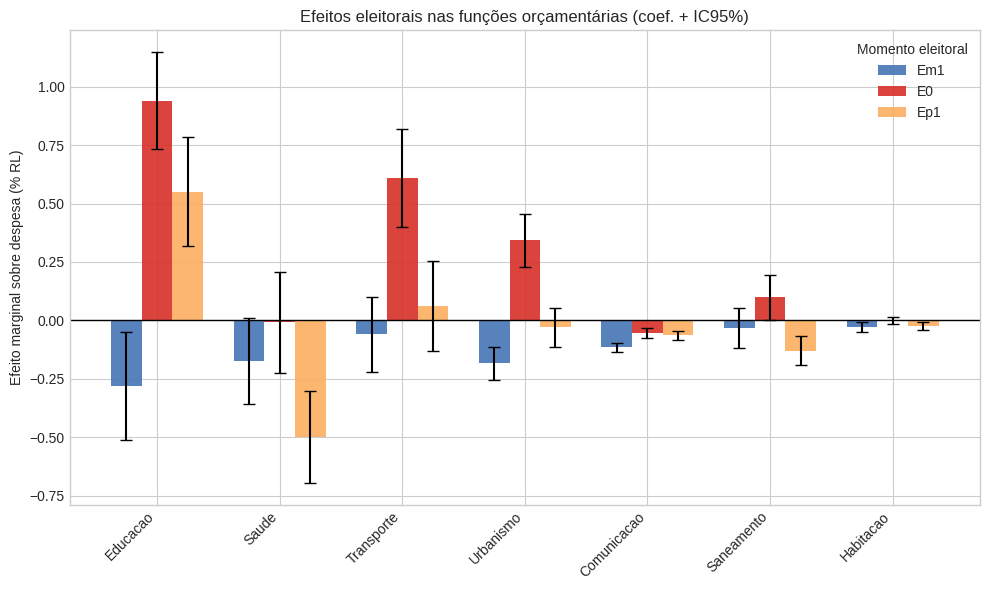

In [ ]:
# ============================================================
# GRÁFICO FINAL — EFEITOS ELEITORAIS (E-1, E0, E+1)
# ============================================================
# ------------------------------------------------------------
# Leitura do resumo consolidado salvo anteriormente
# ------------------------------------------------------------
path = "resultados_finais/modelos_finais_detalhado.csv"
df = pd.read_csv(path)

# Mantém apenas dummies eleitorais
mask = df['Variavel'].isin(['E_m1', 'E_0', 'E_p1'])
df = df[mask].copy()

# Ordena funções para visualização lógica
ordem_funcoes = [
    'EDUCACAO_liq_%RecLiq',
    'SAUDE_liq_%RecLiq',
    'TRANSPORTE_liq_%RecLiq',
    'URBANISMO_liq_%RecLiq',
    'COMUNICACAO_liq_%RecLiq',
    'SANEAMENTO_liq_%RecLiq',
    'HABITACAO_liq_%RecLiq'
]

# Define ordem e cores
variaveis = ['E_m1', 'E_0', 'E_p1']
cores = {'E_m1': '#4575b4', 'E_0': '#d73027', 'E_p1': '#fdae61'}

# ------------------------------------------------------------
# Construção do gráfico
# ------------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 6))

largura_barra = 0.25
posicoes = np.arange(len(ordem_funcoes))

for i, var in enumerate(variaveis):
    subset = df[df['Variavel'] == var].set_index('Funcao').reindex(ordem_funcoes)
    ax.bar(posicoes + i*largura_barra - largura_barra, subset['Coef'],
           yerr=subset['StdErr'], label=var.replace('_', ''),
           width=largura_barra, color=cores[var], alpha=0.9, capsize=4)

ax.axhline(0, color='black', linewidth=1)
ax.set_xticks(posicoes)
ax.set_xticklabels([f.split('_')[0].title() for f in ordem_funcoes], rotation=45, ha='right')
ax.set_ylabel('Efeito marginal sobre despesa (% RL)')
ax.set_title('Efeitos eleitorais nas funções orçamentárias (coef. + IC95%)')
ax.legend(title='Momento eleitoral')
plt.tight_layout()

# Salva figura
os.makedirs('resultados_finais', exist_ok=True)
plt.savefig('resultados_finais/grafico_ciclos_eleitorais.png', dpi=300)
plt.show()


In [ ]:

# ============================================================
# TESTE DE ENDOGENEIDADE: Hausman–Wu (Δlog RL)
# ============================================================

f = "EDUCACAO_liq_%RecLiq"  # exemplo
df = pd.read_csv(f"modelos_ready/modelo_ready_{f}.csv").dropna()
df["uf"] = df["uf"].str.upper().str.strip()
df["ano"] = df["ano"].astype(int)
df = df.set_index(["uf", "ano"])

# -----------------------------------------------
# Criar defasagem da RL (instrumento)
# -----------------------------------------------
df["dlog_RL_lag"] = df.groupby("uf")["dlog_RL"].shift(1)
df = df.dropna(subset=["dlog_RL_lag"])

# -----------------------------------------------
# Variáveis
# -----------------------------------------------
y = df[f]
X_exog = df[["E_m1", "E_0", "E_p1"]]   # regressoras exógenas
X_endog = df["dlog_RL"]                 # potencialmente endógena
Z_instr = df[["dlog_RL_lag"]]           # instrumento exclusivo

# -----------------------------------------------
# Estimação IV (2SLS)
# -----------------------------------------------
iv_mod = IV2SLS(dependent=y, exog=X_exog, endog=X_endog, instruments=Z_instr)
res_iv = iv_mod.fit(cov_type="robust")

print(res_iv)

print("\n=== Interpretação ===")
print("• Se o coeficiente de Δlog(RL) muda muito em relação ao modelo RE/FE clusterizado, há indício de endogeneidade.")
print("• Se é estável e o p-valor permanece alto, Δlog(RL) pode ser tratada como exógena.")



                           IV-2SLS Estimation Summary                           
Dep. Variable:     EDUCACAO_liq_%RecLiq   R-squared:                     -11.811
Estimator:                      IV-2SLS   Adj. R-squared:                -12.062
No. Observations:                   208   F-statistic:                    16.680
Date:                  Sun, Nov 09 2025   P-value (F-stat)                0.0022
Time:                          04:28:27   Distribution:                  chi2(4)
Cov. Estimator:                  robust                                         
                                                                                
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
E_m1          -1.7697     34.610    -0.0511     0.9592     -69.605      66.065
E_0           -29.270     91.868    